In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as skio
import argparse
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Reshape, Dropout, Input, Concatenate, BatchNormalization
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Conv1DTranspose, Conv2DTranspose
from meETL import _floatvector_feature, _float_feature, _int64_feature, _bytes_feature, _dtype_feature, TrainingSet, ETL, MultiEarthETL
from DLKeras import DLKeras
from MultiEarth import Sentinel1, Sentinel2, MultiEarth


%matplotlib inline
%load_ext autoreload
%autoreload 2

2023-06-07 09:29:25.504055: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
IS_JUPYTER = True
AUTOTUNE = tf.data.AUTOTUNE
PROGRESS_INTERVAL = 10

In [3]:
if IS_JUPYTER:
  sys.argv.append('--model')
  sys.argv.append('s2vunet')
  sys.argv.append('--version')
  sys.argv.append('6')
  sys.argv.append('--trial')
  sys.argv.append('1')
  sys.argv.append('--epoch')
  sys.argv.append('4')
  sys.argv.append('--batch_size')
  sys.argv.append('64')
  sys.argv.append('--arch')
  sys.argv.append('AE')
  sys.argv.append('--epsilon')
  sys.argv.append('1')
  sys.argv.append('--datadir')
  sys.argv.append('/me2023/tfr')
  sys.argv.append('--testpat')
  sys.argv.append('valid_55.tfr')
  sys.argv.append('--xtransform')
  sys.argv.append('YXZ,32,32,2')
  sys.argv.append('--ytransform')
  sys.argv.append('YXZ,32,32,3')

  print(sys.argv)

['/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py', '-f', '/root/.local/share/jupyter/runtime/kernel-e33b00ce-a69c-4c4a-a21e-da5ebc606a09.json', '--model', 's2vunet', '--version', '6', '--trial', '1', '--epoch', '4', '--batch_size', '64', '--arch', 'AE', '--epsilon', '1', '--datadir', '/me2023/tfr', '--testpat', 'valid_55.tfr', '--xtransform', 'YXZ,32,32,2', '--ytransform', 'YXZ,32,32,3']


In [4]:
parser = argparse.ArgumentParser()
parser.add_argument("--model", help="model name")
parser.add_argument("--version", type=int, default=1, help="model version")
parser.add_argument("--trial", type=int, default=1, help="training trial number")
parser.add_argument("--epoch", type=int, default=0, help="model epoch")
parser.add_argument("--epsilon", default=1.0, help="epsilon")
parser.add_argument("--xtransform", default='-', help="X transform")
parser.add_argument("--ytransform", default='-', help="Y transform")
parser.add_argument("--arch", default="NR", help="model architecture")
parser.add_argument("--batch_size", type=int, default=8192, help="batch size")
parser.add_argument('--datadir', default="./tfr", help='data directory')
parser.add_argument('--testpat', default="test_*.tfr", help='test file glob pattern')

_StoreAction(option_strings=['--testpat'], dest='testpat', nargs=None, const=None, default='test_*.tfr', type=None, choices=None, help='test file glob pattern', metavar=None)

In [5]:
if IS_JUPYTER:
  args = parser.parse_args(sys.argv[3:])
else:
  args = parser.parse_args()

print(args)

Namespace(arch='AE', batch_size=64, datadir='/me2023/tfr', epoch=4, epsilon='1', model='s2vunet', testpat='valid_55.tfr', trial=1, version=6, xtransform='YXZ,32,32,2', ytransform='YXZ,32,32,3')


In [6]:
parameter = {
  'batch_size': args.batch_size,
}

parameter['name'] = args.model
parameter['version'] = args.version
parameter['trial'] = args.trial
parameter['epoch'] = args.epoch
parameter['epsilon'] = args.epsilon
parameter['arch'] = args.arch
parameter['xtransform'] = args.xtransform
parameter['ytransform'] = args.ytransform
print(parameter)

{'batch_size': 64, 'name': 's2vunet', 'version': 6, 'trial': 1, 'epoch': 4, 'epsilon': '1', 'arch': 'AE', 'xtransform': 'YXZ,32,32,2', 'ytransform': 'YXZ,32,32,3'}


In [7]:
# Create a MirroredStrategy.
#strategy = tf.distribute.MirroredStrategy()
#print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# Open a strategy scope.
#with strategy.scope():
# Everything that creates variables should be under the strategy scope.
# In general this is only model construction & `compile()`.
sar2vis = DLKeras(parameter)
sar2vis.ParseTransform(args.xtransform, args.ytransform)
#sar2vis.path = os.path.join(".", sar2vis.GetModelName())
sar2vis.LoadModel()
sar2vis.model.summary()


2023-06-07 09:29:50.495560: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-07 09:29:50.516001: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-07 09:29:50.516173: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-07 09:29:50.517190: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, r

Loading  ./model/s2vunet-v6t1-e4
Model: "s2vunet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sar (InputLayer)               [(None, 32, 32, 2)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 128)  2432        ['sar[0][0]']                    
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 32, 32, 128)  512        ['conv2d_1[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 tf.nn.relu_1 (TFOpLambda)      (None, 32, 32, 128)  0     

Total params: 3,557,893
Trainable params: 3,553,285
Non-trainable params: 4,608
__________________________________________________________________________________________________


In [8]:
me = MultiEarth()
print(me.Examples())

268602


In [9]:
!head selected.csv

In [10]:
manifest = np.loadtxt("selected.csv", delimiter=",", skiprows=1, dtype=int)
print(manifest.shape[0],'Training examples')

191907 Training examples


Shape: 256,256,2
Mean: -10.612848 Std: 4.263208
idxS2 < N = 0 < 3 = 1
Sentinel1 plot VH for example 221


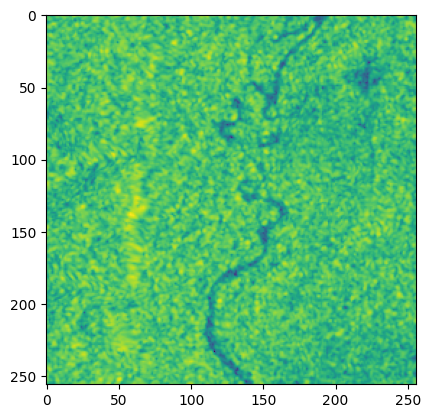

In [11]:
ex = 100
idxS1 = manifest[ex][0]
idxS2 = manifest[ex][1]
sent1, sent2, nSent2 = me.SampleSet(idxS1)
sent1.Statistics()
sent1.Histogram(bins=10)
print('idxS2 < N = %d < %d = %d' %(idxS2, nSent2, idxS2<nSent2))
print('Sentinel1 plot VH for example %d' % (idxS1))
sent1.Plot(0)

Sentinel1 plot VV for example 221


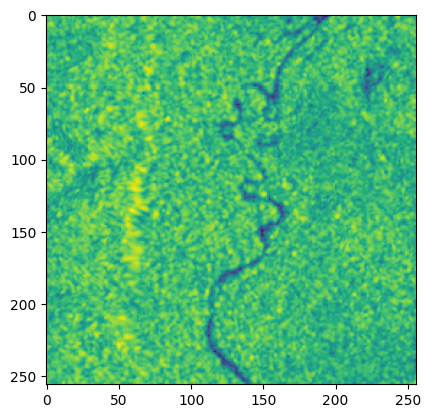

In [12]:
print('Sentinel1 plot VV for example %d' % (idxS1))
sent1.Plot(1)

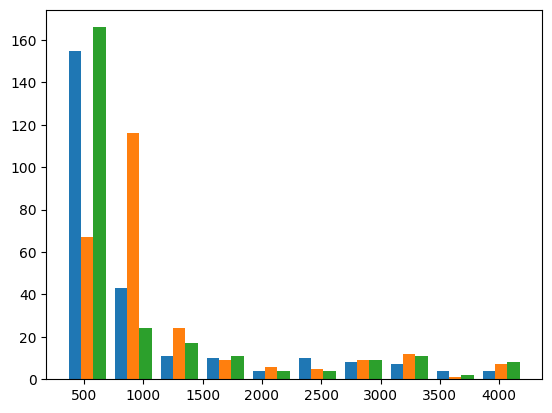

In [13]:
sent2[idxS2].Statistics()
sent2[idxS2].Histogram(bins=10)


In [14]:
if False:
  print('Sentinel2 example %d sample %d' % (idxS1, idxS2))
  print('  plot B4/red')
  sent2[idxS2].Plot(0)
  print('  plot B3/green')
  sent2[idxS2].Plot(1)
  print('  plot B2/blue')
  sent2[idxS2].Plot(2)

In [15]:
sent1.Crop(cropsize=32)
sent2[idxS2].Crop(cropsize=32)

In [16]:
x = []
y = []
for c in range(sent2[idxS2].GetCrops()):
  img1 = sent1.GetCrop(crop=c)
  img2 = sent2[idxS2].GetCrop(crop=c)
  x.append(img1)
  y.append(img2)
x = np.asarray(x)    
y = np.asarray(y)
x.shape

(64, 32, 32, 2)

In [17]:
pred = sar2vis.Predict(x)

2023-06-07 09:30:36.166444: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700


1/1 [==============================] - 0s 473ms/step


In [18]:
yPred = pred[0]
if args.arch == 'AE':
  xPred = pred[1]


In [19]:
#for c in range(x.shape[0]):
#  #avg, std, max, min = sent1.GetCropStats(crop=c)
#  frq, bin_edges = np.histogram(x[c])
#  tail = sum(frq[bin_edges[:-1] > 0.4])
#  print('crop', c, 'last bin', bin_edges[-1], 'next bin', bin_edges[-2], 'tail', tail)
#  plt.subplot(1, 2, 1)
#  plt.imshow(y[c])
#  plt.subplot(1, 2, 2)
#  plt.imshow(ypred[c])   
#  plt.show()
  

In [20]:
img = np.empty((256,256,3))
c = 0
for iy in range(8):
  for ix in range(8):
    img[iy*32:(iy+1)*32,ix*32:(ix+1)*32] = yPred[c]
    c += 1

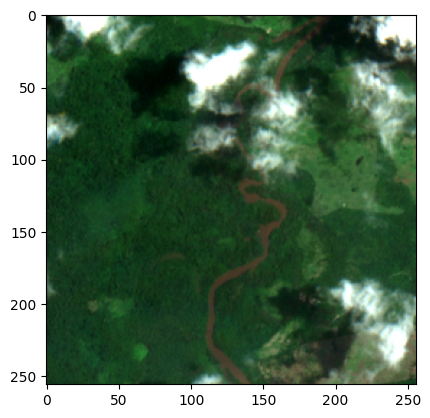

In [21]:
sent2[idxS2].Plot()

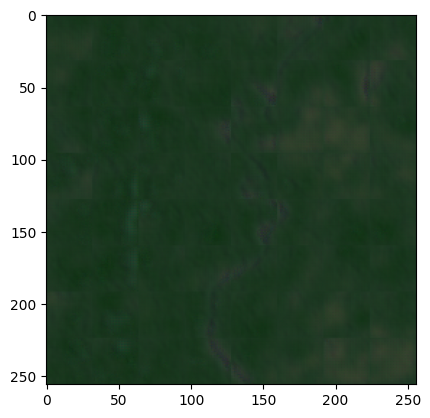

In [22]:
plt.imshow(img)
plt.show()

In [24]:
img = np.empty((256,256,2))
c = 0
for iy in range(8):
  for ix in range(8):
    img[iy*32:(iy+1)*32,ix*32:(ix+1)*32] = xPred[c]
    c += 1

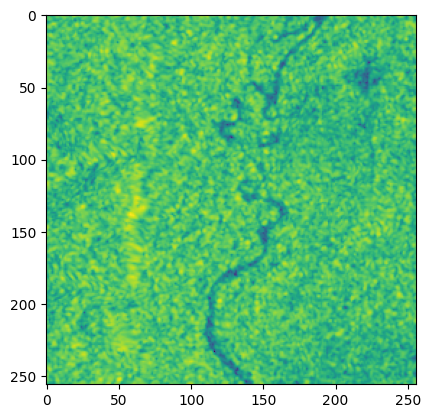

In [29]:
sent1.Plot(0)

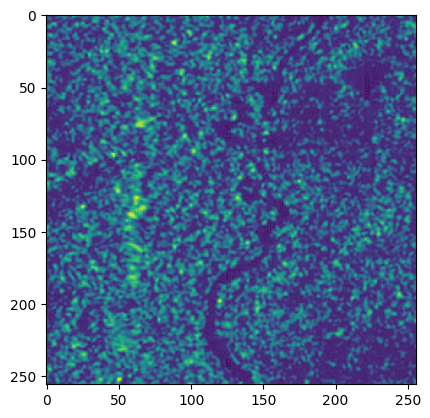

In [30]:
plt.imshow(img[:,:,0])
plt.show()

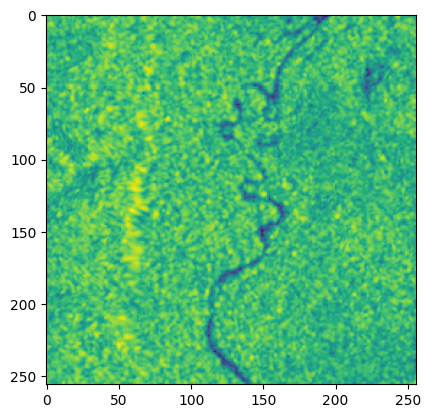

In [31]:
sent1.Plot(1)

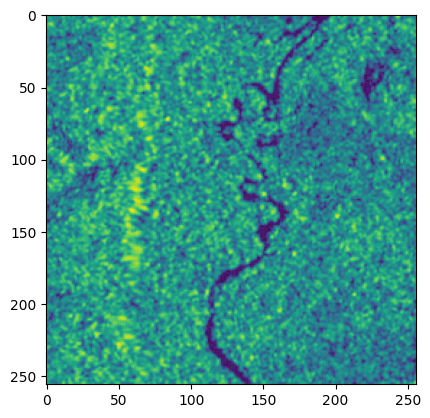

In [32]:
plt.imshow(img[:,:,1])
plt.show()

In [ ]:
img = sent2[idxS2].GetCrop(crop=1)

In [ ]:
plt.imshow(img)
plt.show()

In [ ]:
frq, bin_edges = np.histogram(img)

In [ ]:
frq

In [ ]:
bin_edges

In [ ]:
plt.bar(bin_edges[:-1], frq, width=np.diff(bin_edges), edgecolor="black", align="edge")

In [53]:
!ls /me2023/multiearth2023-dataset-final/translation

SAR2EO_Sentinel2_EO_-54.82_-3.87_2021_07_03_1.tiff
SAR2EO_Sentinel2_EO_-54.82_-3.87_2021_07_03_2.tiff
SAR2EO_Sentinel2_EO_-54.82_-3.87_2021_07_03_3.tiff


In [39]:
!ls /me2023/multiearth2023-dataset-final/sar2eo|grep 54.82_-3.87_2021_07_03 

Sentinel-1_VH_-54.82_-3.87_2021_07_03.tiff
Sentinel-1_VV_-54.82_-3.87_2021_07_03.tiff


In [40]:
sar2eo_path = '/me2023/multiearth2023-dataset-final/sar2eo'
vh_path = sar2eo_path + '/' + 'Sentinel-1_VH_-54.82_-3.87_2021_07_03.tiff'
vv_path = sar2eo_path + '/' + 'Sentinel-1_VV_-54.82_-3.87_2021_07_03.tiff'

In [49]:
# For each VH file in path /me2023/multiearth2023-dataset-final/sar2eo
sent1 = Sentinel1(vh_path, vv_path)
sent1.imvh.shape

(256, 256)

In [42]:
sent1.Crop(cropsize=32)
x = []
for c in range(sent1.GetCrops()):
  img1 = sent1.GetCrop(crop=c)
  x.append(img1)
x = np.asarray(x)

In [43]:
pred = sar2vis.Predict(x)
yPred = pred[0]

1/1 [==============================] - 0s 109ms/step


In [44]:
img = np.empty((256,256,3))
c = 0
for iy in range(8):
  for ix in range(8):
    img[iy*32:(iy+1)*32,ix*32:(ix+1)*32] = yPred[c]
    c += 1

In [50]:
import skimage.io as skio
pred_path = '/me2023/multiearth2023-dataset-final/translation'
c = 0
fname = 'SAR2EO_Sentinel2_EO_-54.82_-3.87_2021_07_03_%d.tiff' % (c+1)
fpath = pred_path + '/' + fname
skio.imsave(fpath, yPred[:,:,c], plugin="tifffile")


/tmp/ipykernel_41818/3454409004.py:6: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel2_EO_-54.82_-3.87_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fpath, yPred[:,:,c], plugin="tifffile")


In [51]:
c = 1
fname = 'SAR2EO_Sentinel2_EO_-54.82_-3.87_2021_07_03_%d.tiff' % (c+1)
fpath = pred_path + '/' + fname
skio.imsave(fpath, yPred[:,:,c], plugin="tifffile")

/tmp/ipykernel_41818/3062625714.py:4: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel2_EO_-54.82_-3.87_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fpath, yPred[:,:,c], plugin="tifffile")


In [52]:
c = 2
fname = 'SAR2EO_Sentinel2_EO_-54.82_-3.87_2021_07_03_%d.tiff' % (c+1)
fpath = pred_path + '/' + fname
skio.imsave(fpath, yPred[:,:,c], plugin="tifffile")

/tmp/ipykernel_41818/2152329900.py:4: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel2_EO_-54.82_-3.87_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fpath, yPred[:,:,c], plugin="tifffile")


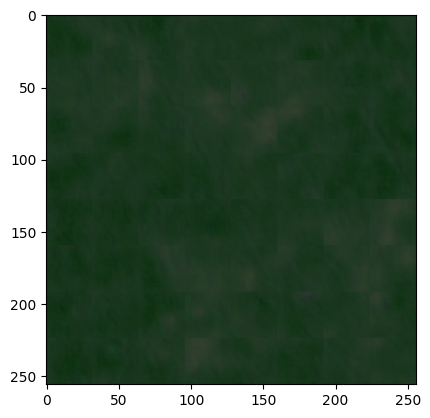

In [45]:
plt.imshow(img)
plt.show()

In [75]:
def Translate(root, vh_path, vv_path):
  pred_path = '/me2023/multiearth2023-dataset-final/translation'
  eo_pat = vh_path.replace('Sentinel-1','Sentinel2')
  eo_pat = eo_pat.replace('_VH_','_EO_')
  eo_pat = eo_pat.replace('.tiff','_%d.tiff')
  eo_pat = 'SAR2EO_' + eo_pat 
  sent1 = Sentinel1(os.path.join(root, vh_path), os.path.join(root,vv_path))
  sent1.Crop(cropsize=32)
  x = []
  for c in range(sent1.GetCrops()):
    img1 = sent1.GetCrop(crop=c)
    x.append(img1)
  x = np.asarray(x)
  pred = sar2vis.Predict(x)
  yPred = pred[0]
  img = np.empty((256,256,3))
  c = 0
  for iy in range(8):
    for ix in range(8):
      img[iy*32:(iy+1)*32,ix*32:(ix+1)*32] = yPred[c]
      c += 1
  for c in range(3):
    fname = eo_pat % (c+1)
    fname = pred_path + '/' + fname
    print('Translating EO', fname)
    skio.imsave(fname, yPred[:,:,c], plugin="tifffile")

In [80]:
sar2eo_path = '/me2023/multiearth2023-dataset-final/sar2eo'
for (root, dirs, file) in os.walk(sar2eo_path):
    for f in file:
        if '_VH_' in f:
            print('Translating ',f)
            vh_path = f
            vv_path = f.replace('_VH_','_VV_')  
            Translate(root,vh_path,vv_path)

Translating  Sentinel-1_VH_-54.82_-4.37_2021_02_27.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_02_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_02_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_02_27_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.99_2019_04_09.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_02_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_02_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_02_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2020_07_02.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.29_2020_10_18.tiff
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.11_2019_08_07.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.17_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2019_04_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.86_-4.13_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.95_2020_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_05_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_05_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.87_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_09_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_05_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.21_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_05_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.05_2020_10_12.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2019_06_20.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_10_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_10_19_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.01_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_09_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_09_30_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.93_2019_02_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_02_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_02_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_02_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.31_2020_08_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_08_25_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_02_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_02_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_02_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_08_25_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_08_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_05_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.25_2020_05_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_05_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_05_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_05_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_05_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_05_27_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2020_08_13.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_08_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_05_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.33_2020_08_19.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_08_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2019_07_14.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_07_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.29_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.87_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.99_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_03_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.05_2020_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_10_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.05_2019_05_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_05_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_05_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_05_27_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_05_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_05_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_05_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.31_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2021_06_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_06_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_06_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_06_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_06_27_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_07_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_06_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_06_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_06_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.01_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.33_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.01_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_03_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.88_-3.91_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.39_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2019_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.23_2019_03_28.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_03_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2019_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_03_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_03_04_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.87_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_07_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.07_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2020_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_04_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_04_09_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.25_2020_12_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_12_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_12_29_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_12_29_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_11_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_11_29_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.35_2020_03_10.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.35_2020_06_20.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.15_2020_10_12.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_10_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.97_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_09_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_09_18_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_06_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.89_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.01_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.19_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_09_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_09_18_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_08_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.15_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.21_2021_01_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_01_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_01_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_01_10_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.07_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_06_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_01_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.80_-4.31_2020_10_12.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_07_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_08_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.95_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_08_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.99_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.95_2019_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_10_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_10_06_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_10_06_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.80_-4.07_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.09_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_06_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.19_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_06_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.29_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_08_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.31_2020_05_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_05_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_05_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_05_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.27_2020_01_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_01_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_05_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_05_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_05_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_01_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_01_10_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.31_2021_10_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_10_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_01_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_10_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_10_13_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2020_04_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_04_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_04_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_04_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.07_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.87_2020_07_20.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.21_2021_12_06.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_12_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_12_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_12_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_12_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_12_06_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.89_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_06_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_06_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_12_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.37_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2020_03_22.tiff
1/1 [==============================] - ETA: 0s

/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.99_2020_06_08.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.31_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_03_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.99_2021_09_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_09_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_09_01_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_09_01_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_09_06_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.37_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.35_2021_05_04.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_05_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2021_04_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_04_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_04_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_04_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_04_28_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.21_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_07_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_04_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_04_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.82_-4.25_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2021_03_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_03_29_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_03_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_03_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_03_29_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.01_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_07_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_03_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_03_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.11_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_07_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.39_2021_06_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_06_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_06_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_06_27_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2020_09_12.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_09_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_06_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_06_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_06_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.97_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_06_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_06_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.84_-4.25_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.39_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_08_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_10_18_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.93_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_08_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2020_07_26.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.31_2021_08_02.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2021_08_03.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_08_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_08_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_08_03_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2020_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_06_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_08_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_08_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_08_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_06_21_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2020_02_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_02_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_02_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_02_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_02_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_02_21_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.23_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_07_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_02_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2020_03_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_03_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_03_11_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_03_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_03_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_03_11_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.23_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_08_01_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_03_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.07_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.01_2019_04_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_04_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_04_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_04_21_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.99_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_05_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_06_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_06_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.11_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_05_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_05_04_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.03_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.97_2020_11_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_11_11_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_11_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_11_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_11_11_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.11_2019_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_03_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_11_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_11_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_03_04_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.29_2021_06_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_06_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_06_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_06_27_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_06_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_06_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_06_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.35_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.29_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_08_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.03_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_10_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.99_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_07_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.31_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.21_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_08_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.37_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_08_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2020_02_03.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_02_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_02_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_02_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_02_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_02_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_02_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.25_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_05_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.35_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_05_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2021_09_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_09_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_09_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_09_01_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.88_-4.21_2021_10_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_10_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_10_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_10_13_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2021_06_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_06_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_06_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_06_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_06_28_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.99_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_07_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_06_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_06_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_09_06_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.03_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.15_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_03_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.03_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_03_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.15_2021_12_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_12_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_12_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_12_06_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_12_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_12_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_12_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.35_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.93_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2019_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.27_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_06_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.25_2019_01_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_01_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_01_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_01_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_01_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_01_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_01_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.07_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_09_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.89_2021_04_22.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_04_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_04_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_04_22_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.39_2021_02_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_02_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_04_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_04_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_04_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_02_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_02_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_02_27_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.25_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_07_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_02_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_02_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.33_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_07_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_08_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.35_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_07_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.15_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_08_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.11_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_07_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.99_2020_02_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_02_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_02_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_02_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_02_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_02_21_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2021_07_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_02_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.19_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_04_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.99_2021_12_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_12_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_12_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_12_18_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.95_2021_09_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_09_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_12_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_12_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_12_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_09_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_09_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_09_07_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.99_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_09_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_09_18_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_09_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_09_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.01_2021_11_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_11_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_11_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_11_24_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_11_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_11_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_11_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.87_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.37_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2020_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_05_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_05_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2020_09_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_13_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.35_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_06_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.23_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2021_06_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.33_2019_05_03.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_05_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_05_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_05_03_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.39_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_12_11_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_05_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_05_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_05_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_12_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2021_09_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_09_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_09_01_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_09_01_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.25_2020_08_13.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_08_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2020_04_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_04_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_04_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_04_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_04_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_04_15_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_08_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_04_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.15_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_03_04_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.97_2020_11_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_11_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_11_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_11_11_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.03_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_08_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_11_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_11_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_11_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.15_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_08_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.01_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_05_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2021_01_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_01_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_01_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_01_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_01_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_01_22_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.31_2019_10_06.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_10_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_01_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_10_06_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.01_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_08_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_10_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_10_19_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.13_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_06_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.89_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_08_01_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.87_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_03_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.31_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.37_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_03_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.21_2021_12_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_12_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_12_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_12_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_12_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_12_06_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.25_2019_07_26.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_07_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_12_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.29_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.33_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_09_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.35_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_06_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.95_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.91_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.07_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_07_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.11_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_07_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.13_2020_11_05.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_11_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_11_05_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_11_05_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_11_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_11_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_11_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.91_2020_03_10.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.97_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_08_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.01_2019_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_03_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_03_04_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.15_2021_12_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_12_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_12_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_12_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_12_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_12_06_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_08_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_12_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.03_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_06_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.25_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.05_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_09_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_05_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.39_2020_03_28.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_03_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_03_28_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.17_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_07_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.35_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_08_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.15_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_08_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.35_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_07_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2020_12_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_12_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_12_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_12_23_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_12_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_12_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_12_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.25_2019_01_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_01_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_01_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_01_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2020_05_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_05_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_01_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_01_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_01_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_05_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_05_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_05_21_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.11_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_05_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_05_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_05_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2020_09_18.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_09_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_09_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.01_2020_10_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_10_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_10_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_10_24_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.21_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_09_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_08_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_08_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.97_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.03_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_10_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.27_2020_05_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_05_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_05_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_05_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_05_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_05_21_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2021_12_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_12_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_12_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_12_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_05_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_12_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_12_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_12_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.27_2019_12_05.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_12_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_12_05_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_12_05_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.35_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_12_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_12_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_12_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2020_12_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_12_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_12_29_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_12_29_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2020_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_05_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.01_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.01_2021_01_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_01_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_01_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_01_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_01_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_01_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_01_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.39_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_08_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.19_2020_07_20.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.99_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_06_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2019_04_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_04_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_04_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_04_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_04_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_04_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.93_2020_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_03_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_04_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.25_2019_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2019_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2019_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2019_03_04_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.35_2019_04_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_04_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2019_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2019_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2019_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_04_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_04_21_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.19_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_05_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.86_-4.17_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_06_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_06_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.88_-4.39_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.97_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_06_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_06_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.29_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_03_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.87_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.15_2021_11_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_11_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_11_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_11_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_11_30_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.97_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_08_01_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_11_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_11_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.86_-3.99_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.29_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_06_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.31_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_07_27_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.09_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2021_08_15.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_08_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_08_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_08_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2019_02_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_02_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_08_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_08_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_08_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_02_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_02_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_02_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.19_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_08_01_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_02_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_02_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.17_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_05_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.99_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.19_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_07_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_07_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.01_2021_10_07.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_10_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.27_2021_08_08.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.31_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.33_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_07_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_04_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.01_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.11_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_07_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.95_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2021_04_22.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_04_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_04_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_04_22_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.91_2021_04_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_04_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_04_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_04_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_04_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_04_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_04_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_04_16_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.29_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_10_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_04_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.05_2021_09_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_09_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_09_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_09_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.99_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2019_04_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_09_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_09_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_09_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_06_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.25_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_09_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_09_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.05_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_10_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.13_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.25_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2019_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_03_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_03_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.25_2019_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_10_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_10_30_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.89_2020_11_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_11_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_11_11_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_11_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_11_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_11_11_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.19_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_07_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_11_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.99_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.27_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_12_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.33_2019_03_28.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.23_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_07_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.86_-4.31_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_10_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_10_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.82_-3.95_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2020_08_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_25_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_25_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_05_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.87_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_06_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.07_2020_07_20.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2021_11_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_11_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_11_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_11_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_11_30_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2020_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_10_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_10_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_11_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_11_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_10_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2021_09_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_09_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_09_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_09_25_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_09_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_09_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_09_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.35_2020_05_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_05_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_05_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_05_27_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.27_2020_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_03_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_05_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_05_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_05_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_03_28_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_08_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.05_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_07_27_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.87_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2020_06_02.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_06_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.35_2019_10_30.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_10_30_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.95_2021_10_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_10_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_10_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_10_13_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.05_2021_01_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_01_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_01_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_01_10_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.35_2020_06_20.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_01_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.05_2020_11_29.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_11_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.25_2020_12_29.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_12_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_12_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_12_29_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.35_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_03_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.13_2021_08_08.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.29_2021_11_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_11_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_11_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_11_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_11_18_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.09_2021_12_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_12_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_12_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_12_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_11_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_11_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_12_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_12_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.80_-4.35_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_10_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_07_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.93_2018_12_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2018_12_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2018_12_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2018_12_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2018_12_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2018_12_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.88_-3.89_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.97_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_08_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_08_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.39_2020_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_03_28_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.05_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_09_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.07_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_05_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.37_2021_09_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_09_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_09_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_09_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.05_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_08_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_09_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_09_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_09_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.29_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_10_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_10_19_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2020_11_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_11_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_11_11_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_11_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_11_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_11_11_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_08_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_11_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.15_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.21_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2021_10_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.21_2021_10_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_10_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_10_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_10_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_10_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_10_31_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_07_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_10_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.95_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_11_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.95_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_11_29_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.33_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_07_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.39_2021_02_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_02_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_02_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_02_27_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_02_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_02_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.86_-4.01_2019_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_09_24_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.35_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.31_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_07_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.11_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.29_2021_06_27.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_06_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_06_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_06_27_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_07_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_06_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_06_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_06_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.01_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2020_10_18.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2020_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_07_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_07_27_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.33_2019_01_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_01_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_01_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_01_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_01_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_01_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.86_-4.37_2019_02_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2019_02_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2019_02_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2019_02_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_07_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2019_02_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2019_02_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2019_02_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.97_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.99_2021_06_15.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_06_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.89_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_06_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.27_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_03_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.31_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.25_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_05_04_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.97_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_05_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.88_-4.19_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.21_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_09_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.05_2019_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_10_06_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2021_07_15.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.25_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_07_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2019_12_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_12_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_12_05_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_12_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_12_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_12_05_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.31_2021_08_02.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_08_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_12_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.89_2021_12_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_12_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_12_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_12_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_12_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_12_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_12_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.89_2020_12_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_12_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_12_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_12_23_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.09_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_08_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_12_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_12_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_12_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.89_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.15_2020_03_04.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_03_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.13_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_03_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.82_-4.05_2021_12_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_12_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_12_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_12_06_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.87_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_12_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_12_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_12_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_05_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.33_2020_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.99_2019_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_03_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.15_2021_10_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_10_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_10_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_10_13_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.89_2020_02_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_02_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_02_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_02_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_02_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_02_03_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.27_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_08_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_02_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.11_2021_01_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_01_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_01_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_01_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.29_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2019_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_01_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_01_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_01_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_06_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_06_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.11_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_06_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.09_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2019_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2019_03_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.25_2019_04_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_04_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_04_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_04_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.97_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_03_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.95_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_09_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.87_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_06_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.15_2021_10_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_10_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_10_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_10_31_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.09_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_06_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_10_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_10_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_10_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.03_2021_03_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_03_29_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_03_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_03_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_03_29_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.37_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_08_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_03_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_03_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.99_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_06_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_06_09_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.95_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_09_24_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.93_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_10_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.17_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_06_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_06_09_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_11_29_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.11_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_03_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2021_11_12.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_11_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.23_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_07_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.15_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2019_07_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.23_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.97_2021_09_01.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_09_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_09_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_09_01_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.91_2021_06_21.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.89_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_07_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2021_05_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_05_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_05_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.21_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.95_2021_10_13.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_10_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_10_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_10_13_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.19_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_05_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.35_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_07_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.03_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.21_2021_11_30.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_11_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_11_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_11_30_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.93_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_03_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_11_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_11_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_11_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2020_08_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_08_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_08_25_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_08_25_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_07_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.23_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_05_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.89_2020_08_19.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_08_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.05_2021_03_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_03_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_03_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_03_23_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.01_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_03_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_03_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_03_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_10_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.33_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_08_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.03_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_07_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.35_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.31_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.35_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_06_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2021_06_03.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_06_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.97_2020_09_18.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_09_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_09_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.17_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_06_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2020_03_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_23_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_23_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2021_09_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_09_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_09_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_09_01_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.23_2020_11_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_11_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_11_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_11_11_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2020_08_25.tiff
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_11_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_11_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_11_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_08_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_08_25_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_08_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.15_2021_11_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_11_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_11_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_11_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_11_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_11_30_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.97_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_08_01_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_11_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.37_2020_01_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_01_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_01_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_01_10_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.05_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_09_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_01_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.05_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_05_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.84_-3.97_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.89_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_06_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_06_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_06_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.91_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.17_2020_07_02.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_04_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.15_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_11_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2019_05_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.25_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_06_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.25_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.25_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_10_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_10_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.19_2020_12_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_12_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_12_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_12_23_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.87_2021_04_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_04_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_12_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_12_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_12_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_04_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_04_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_04_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.03_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_08_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_04_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_04_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.15_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_08_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.95_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.93_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_08_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.37_2020_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_03_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_03_28_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.99_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_08_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_07_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.17_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.25_2020_07_14.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.03_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.35_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_07_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.23_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_07_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.93_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_05_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_05_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.95_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_09_06_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.09_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2020_08_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_08_25_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_08_25_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.93_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_03_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.01_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_08_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_06_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.31_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.35_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_09_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2020_12_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_12_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_12_23_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_12_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_12_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_12_23_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.03_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_07_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_12_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.33_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.11_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_10_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.99_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_08_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.21_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.23_2020_07_02.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.23_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_04_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_11_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_11_29_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.87_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.97_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.13_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_10_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.82_-3.89_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.97_2021_09_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_09_01_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_09_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_09_01_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_08_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.39_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_06_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.87_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_12_11_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2020_04_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_04_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_04_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_04_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_04_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_04_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.15_2021_09_25.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_04_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_09_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_09_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_09_25_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.09_2020_08_01.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_09_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_09_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_09_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.07_2021_05_28.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.89_2020_07_20.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_07_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.15_2021_01_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_01_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_01_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_01_10_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.23_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_08_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_01_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2019_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_07_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.17_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.25_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_03_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2020_11_29.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_11_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_11_29_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2020_08_31.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_08_31_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.95_2020_07_26.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2021_11_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_11_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_11_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_11_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_11_24_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_05_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_11_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_11_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.21_2021_09_25.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_09_25_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_09_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_09_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_09_25_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2021_01_17.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_01_17_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_09_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_09_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_01_17_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_01_17_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_01_17_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.95_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_03_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_01_17_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_01_17_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_07_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.19_2021_06_15.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_06_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.25_2020_06_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_06_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_06_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.23_2021_09_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2021_09_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2021_09_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2021_09_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2021_09_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2021_09_19_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.99_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2019_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2019_03_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2021_09_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.39_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_08_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2019_04_16.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_04_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_04_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_04_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.37_2019_08_19.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_04_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_04_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_04_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.97_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_08_01_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_07_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.01_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_07_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.97_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_07_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2020_01_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_01_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_01_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_01_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_01_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_01_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_08_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_01_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.37_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.21_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.05_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.27_2021_06_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_06_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_06_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_06_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_06_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_06_27_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.89_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_06_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_06_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_06_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.35_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.99_2020_06_14.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.19_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_06_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.31_2020_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_05_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_05_15_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.29_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_08_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.25_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_08_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.03_2020_11_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_11_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_11_05_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_11_05_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_11_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_11_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_11_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.11_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.17_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_08_01_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.97_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_07_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.91_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_07_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.03_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.07_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2019_02_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_02_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_02_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_02_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_02_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.97_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_05_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_02_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_02_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.88_-4.39_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.27_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_06_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_06_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_06_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.21_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2021_08_14.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.23_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.35_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_08_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.11_2019_04_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_04_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_04_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_04_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.13_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_08_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.95_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_07_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.33_2021_01_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_01_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_01_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_01_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_01_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_01_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.25_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_10_06_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_01_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.11_2021_11_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_11_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_11_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_11_24_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.35_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_07_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_11_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_11_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_11_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.95_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_11_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.27_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_10_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.21_2021_10_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_10_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_10_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_10_31_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.29_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_10_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_10_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_10_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.95_2019_05_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_05_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_05_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_05_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_05_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_05_27_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2021_01_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_01_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_01_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_05_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_01_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_01_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_01_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.11_2021_01_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_01_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_01_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_01_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2021_08_20.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_01_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_01_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_01_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_01_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_08_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.27_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.95_2019_07_14.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.11_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_06_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_06_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.35_2021_06_03.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.33_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_09_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.87_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_06_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.88_-3.95_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_03_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.03_2021_03_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_03_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_03_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_03_29_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_03_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_03_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.82_-3.89_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2020_12_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_12_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_12_23_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_12_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_12_23_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2020_09_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_25_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_12_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_25_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.35_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_07_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.01_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2019_05_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.09_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_07_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.31_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_08_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.13_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.15_2020_03_04.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.89_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_07_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.13_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_06_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.09_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_08_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.37_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.39_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_12_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.29_2020_03_28.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_03_28_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.91_2020_06_02.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_06_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.93_2019_04_09.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.23_2020_11_05.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_11_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_11_05_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_11_05_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.11_2020_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_05_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_11_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_11_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_11_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_05_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.13_2020_02_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_02_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_02_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_02_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_02_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_02_21_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.15_2019_05_15.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2019_05_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_02_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.19_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.11_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_08_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.01_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_08_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.03_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_05_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2021_01_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_01_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_01_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_01_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_01_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_01_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_01_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.37_2021_01_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_01_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_01_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_01_16_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.05_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_05_04_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_01_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_01_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_01_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.39_2020_07_20.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_07_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.23_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_06_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.89_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_03_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.27_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2020_04_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_04_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_04_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_04_21_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_07_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.89_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_06_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.93_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_08_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.93_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.25_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.25_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_08_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.23_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_03_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.93_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_07_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.39_2021_05_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_23_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2020_12_11.tiff
1/1 [==============================] - ETA: 0s

/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_12_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.19_2020_03_28.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_03_28_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2021_10_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_10_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_10_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_10_13_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_06_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.80_-4.21_2021_06_03.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2020_06_14.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_06_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.35_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2019_08_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2020_11_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_11_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_11_05_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_11_05_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_11_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_11_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_11_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.31_2019_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_08_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.01_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_08_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.01_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_09_24_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.39_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2019_04_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.33_2021_09_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_09_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_09_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_09_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.95_2020_09_30.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_09_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_09_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_09_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_09_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.89_2021_08_14.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2020_04_28.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_04_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_04_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_04_28_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2021_01_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_01_23_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_04_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_04_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_04_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_01_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_01_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_01_23_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.21_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_08_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_01_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_01_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.07_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_08_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.11_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.01_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_03_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.17_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_06_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.11_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_09_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2020_10_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_10_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_10_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_10_24_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.91_2021_09_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_09_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_09_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_09_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.09_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_09_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_09_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_09_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.29_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_06_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.35_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_08_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.01_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.35_2021_10_31.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_10_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_10_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_10_31_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.29_2020_04_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_04_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_10_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_10_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_10_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_04_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_04_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_04_27_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.19_2021_08_08.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_08_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_04_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_04_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.15_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_06_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2021_05_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_11_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.99_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_07_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_06_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.27_2019_01_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_01_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_01_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_01_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_01_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_01_03_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2020_06_08.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_06_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_01_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.91_2019_05_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_05_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_05_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_05_27_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.15_2021_01_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_01_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_05_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_05_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_05_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_01_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_01_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_01_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_05_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_01_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_01_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.23_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2021_08_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.87_2020_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_03_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.35_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.07_2020_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_03_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_03_28_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.01_2020_08_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_08_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_08_25_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_08_25_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2020_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_06_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_06_03_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.25_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_07_27_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.95_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_10_06_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.17_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_10_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.95_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.11_2019_07_14.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.27_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.15_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_03_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2020_12_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_12_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_12_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_12_29_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.95_2021_07_15.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_11_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2019_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_10_18_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_10_18_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.97_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.15_2020_06_20.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2019_09_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.15_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_10_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_08_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_18_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.87_2021_03_29.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_03_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_03_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_03_29_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_03_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_03_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_03_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.25_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.35_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2019_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_09_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.11_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_10_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.35_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_06_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.86_-4.05_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2021_06_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_06_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_06_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_06_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_06_27_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.97_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_06_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_06_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_06_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_05_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.97_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_03_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_07_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_08_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.09_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.15_2020_06_02.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_06_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.31_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.09_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_10_18_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.03_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2019_07_02.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.93_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_07_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_07_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2020_11_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_11_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_11_05_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_11_05_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_11_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_11_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_11_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.25_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_06_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_06_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_06_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.01_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_05_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.82_-4.35_2021_01_10.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_01_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_01_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_01_10_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_01_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2020_06_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_06_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_06_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.99_2020_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_03_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_03_28_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.01_2020_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_10_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.33_2018_12_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2018_12_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2018_12_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2018_12_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2018_12_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2018_12_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.05_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_07_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2018_12_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.33_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.15_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_07_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.89_2021_10_19.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_10_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_10_19_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.07_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_12_11_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2021_05_28.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.31_2021_07_09.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.93_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_07_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.23_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_10_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.88_-4.19_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.25_2020_10_30.tiff
1/1 [==============================] - ETA: 0s

/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.93_2019_01_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_01_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_01_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_01_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_01_03_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.87_2020_06_26.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_06_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_01_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_01_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.99_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_08_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.37_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.39_2020_08_01.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2021_10_08.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_10_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_10_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_10_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2020_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_03_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_10_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_10_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_10_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_03_28_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.29_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_06_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.99_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_07_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.91_2020_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_05_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_05_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.25_2021_05_10.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_05_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.21_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.87_2019_12_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_12_05_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_12_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_12_05_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_12_05_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.11_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_11_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_11_29_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_12_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_12_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.11_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_11_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.13_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2019_04_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.17_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.37_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_08_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.07_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2019_07_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.99_2021_08_08.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_08_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.93_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_09_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.11_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_10_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2021_06_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_06_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_06_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_06_27_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_06_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_06_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_06_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.11_2021_09_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_09_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_09_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_09_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.19_2020_05_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_05_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_05_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_09_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_09_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_09_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_05_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_05_21_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_08_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_05_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.25_2020_08_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_08_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_08_25_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.97_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_03_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.39_2020_06_08.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_06_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.31_2019_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_10_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_10_30_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2019_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_08_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_08_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_07_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.21_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2019_06_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_06_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_06_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_06_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_06_27_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2019_09_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_09_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_09_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_06_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_06_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_09_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_09_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_09_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2020_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_09_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.07_2020_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_03_28_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.11_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.95_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_06_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.93_2021_09_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_09_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_09_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_09_01_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2021_10_19.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_10_19_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.31_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_09_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2019_06_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.97_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_10_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.27_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2019_04_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.15_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_03_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2021_07_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_07_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_07_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_07_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_07_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_07_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_07_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.25_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.29_2021_12_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_12_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_12_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_12_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_12_18_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.93_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_07_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_12_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_12_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.80_-4.09_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.11_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_07_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.97_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_08_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.82_-3.95_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.99_2019_08_19.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2019_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_10_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_10_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.07_2021_06_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_06_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_06_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_06_27_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_06_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_06_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_06_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.39_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.11_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_08_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.37_2020_04_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_04_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_04_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_04_27_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_04_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_04_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_04_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.07_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.13_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_04_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.31_2020_12_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_12_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_12_29_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_12_29_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.21_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_03_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.09_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_10_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.31_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.25_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_10_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.01_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_09_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.95_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_07_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.93_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_04_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.11_2021_11_30.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_11_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_11_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_11_30_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.01_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_11_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_11_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_11_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.95_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_08_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.89_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_12_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_12_11_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.07_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_10_19_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.87_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.13_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_05_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.13_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_03_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.89_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_10_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.35_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2020_03_22.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.25_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_10_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_10_19_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.25_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_09_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2021_07_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.93_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.13_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_08_01_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.35_2019_08_31.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.31_2020_08_31.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_08_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.31_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_05_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.99_2021_03_29.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_03_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_03_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_03_29_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_03_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_03_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_03_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.01_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_08_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.82_-4.23_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2020_02_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_02_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_02_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_02_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_02_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.93_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_07_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_02_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_02_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.93_2019_04_09.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_04_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.87_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_08_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.39_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_06_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.11_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_07_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.91_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_09_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.29_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_08_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_05_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_05_04_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.39_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.19_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.21_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_10_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.03_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_05_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_05_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.91_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.93_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2019_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_07_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_07_21_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.89_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.21_2021_11_24.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_11_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_11_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_11_24_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2021_08_02.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_11_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_11_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_11_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.25_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.33_2019_12_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_12_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_12_05_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_12_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_12_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_12_05_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_10_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_12_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.95_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2021_09_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_09_01_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_09_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_09_01_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2021_09_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_09_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_09_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_09_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_09_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_09_13_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.15_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_06_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_09_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.91_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.27_2021_07_03.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.97_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_12_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.23_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_08_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_06_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.88_-4.33_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_04_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_05_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.35_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_09_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.15_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_10_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.21_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_08_13_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.11_2021_10_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_10_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_10_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_10_13_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.95_2020_06_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_06_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.89_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_08_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.11_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.15_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_05_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_05_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_06_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.01_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2020_08_02.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.39_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_06_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_06_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_06_09_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.29_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_06_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.33_2020_10_18.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.29_2020_04_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_04_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_04_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_04_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_04_27_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.87_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_07_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_04_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_04_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.86_-4.21_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.21_2020_05_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_05_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_05_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_05_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_05_27_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2021_11_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_11_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_05_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_05_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_11_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_11_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_11_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.39_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_06_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_11_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_11_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_03_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.82_-3.87_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.29_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.31_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_07_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.21_2020_07_14.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.37_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_07_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2021_01_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_01_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_01_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_01_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_01_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2020_06_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_06_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_06_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_01_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_01_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.82_-4.25_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.89_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_08_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.25_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2019_09_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_08_31_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.86_-3.93_2020_12_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_12_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_12_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_12_23_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_12_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_12_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_12_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.27_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_08_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.95_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_07_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.15_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.37_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_04_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.88_-4.03_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.35_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_11_29_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.03_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_06_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_06_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_06_09_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2020_09_12.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_09_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.35_2021_01_10.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_01_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_01_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_01_10_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.87_2020_10_18.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_01_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.09_2020_11_05.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_11_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_11_05_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_11_05_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.35_2020_08_07.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_11_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_11_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_11_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_08_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.97_2021_03_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_03_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_03_29_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_03_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_03_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_03_29_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.23_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_08_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_03_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.09_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2019_06_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.11_2020_08_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_08_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_08_25_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.39_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_07_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.01_2020_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_10_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.01_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_07_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.01_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_08_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2020_04_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_04_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_04_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_04_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_04_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_04_27_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_08_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_04_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.31_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.95_2020_02_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_02_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_02_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_02_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_02_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.35_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_05_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_02_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_02_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.03_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_04_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.07_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_07_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.21_2020_12_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_12_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_12_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_12_29_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.03_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2019_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_08_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_08_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.21_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_07_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2020_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_06_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_06_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.29_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_08_01_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.97_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.95_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_05_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2021_01_23.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_01_23_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_01_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_01_23_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.01_2021_07_27.tiff
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_01_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_01_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_01_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2021_09_01.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_09_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_09_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_09_01_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.99_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_12_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2020_10_30.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_07_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.29_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_07_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.95_2019_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_09_24_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2021_08_02.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_08_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.97_2020_11_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_11_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_11_05_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_11_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_11_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_11_05_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.13_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_08_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_11_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.97_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.11_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_05_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.15_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_09_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.11_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.11_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.33_2020_05_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_05_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_05_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_05_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_05_21_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.89_2021_03_29.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_03_29_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_05_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_05_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_03_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_03_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_03_29_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_05_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_03_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_03_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.93_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_08_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_07_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_07_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.11_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_08_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.21_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.29_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_09_24_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.21_2021_05_22.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_05_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.33_2020_06_26.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_06_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.19_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_10_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.05_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_07_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.95_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_07_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2019_06_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.19_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_12_11_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_08_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.13_2019_03_16.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2019_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2019_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2019_03_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2019_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2019_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2019_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_05_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.29_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_03_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.95_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_09_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_03_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.33_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_06_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.03_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_07_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.05_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_08_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2020_10_12.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_10_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2021_08_26.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_08_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.09_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.01_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.15_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_08_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.05_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_06_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.25_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_08_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.89_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_06_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.88_-3.89_2020_10_18.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.89_2020_11_05.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_11_05_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_11_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_11_05_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_11_05_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.01_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_09_24_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_11_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_11_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.07_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_10_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.99_2021_03_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_03_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_03_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_03_29_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.93_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_03_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_03_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_03_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.05_2020_10_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_10_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_10_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_10_24_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.39_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_06_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_08_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.15_2019_07_26.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_07_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.29_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_06_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_06_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_08_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.97_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_07_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_07_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.37_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.25_2021_10_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_10_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_10_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_10_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_10_31_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.15_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_05_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_10_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_10_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2020_05_15.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_05_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2020_06_08.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.89_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_06_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2021_07_27.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_07_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.11_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_03_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.17_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2021_05_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_29_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_29_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.21_2021_01_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_01_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_01_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_01_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_01_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_01_22_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_05_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_01_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.19_2019_08_19.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.13_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_05_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.29_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_07_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.15_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_05_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_05_04_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.13_2019_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_03_16_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.01_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_03_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2019_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_08_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_08_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.07_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.11_2021_08_20.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2019_03_04.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_03_04_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_03_04_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2021_10_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_10_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_10_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_10_13_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.29_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_03_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.17_2020_05_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_05_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_05_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_05_21_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_05_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_05_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_05_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2019_12_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2019_12_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2019_12_05_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2019_12_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2019_12_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2019_12_05_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.19_2021_06_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_06_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_06_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_06_27_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2019_12_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_06_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_06_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_06_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.31_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.29_2020_06_14.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.97_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_08_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2021_10_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_10_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_10_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_10_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_10_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_10_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.35_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_09_24_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_10_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.25_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_08_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.15_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_07_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.93_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2021_05_10.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_05_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2020_10_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_10_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_10_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_10_13_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.89_2021_03_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_03_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_03_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_03_29_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_03_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_03_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_03_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.31_2021_06_03.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.91_2019_06_20.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2019_09_12.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_09_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.95_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_10_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.29_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_04_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.99_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_10_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.21_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.11_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_08_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.35_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_03_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.25_2021_12_06.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_12_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_12_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_12_06_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_12_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_12_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_12_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.33_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.05_2021_01_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_01_04_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_01_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_01_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_01_04_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.35_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_09_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_01_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_01_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2020_04_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_04_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_04_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_04_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.05_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_08_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.15_2021_11_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_11_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_11_24_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_11_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_11_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_11_24_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2021_03_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_03_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_03_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_03_23_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2020_07_26.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_11_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_03_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_03_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_03_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.39_2020_06_14.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_06_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.15_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.87_2021_06_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_06_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_06_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_06_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_06_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_06_27_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.15_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_05_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_06_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.03_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_09_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.05_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_06_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.23_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_10_18_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_07_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.97_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.97_2019_08_19.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2020_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_21_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.99_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_08_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.39_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_07_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.01_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.01_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_03_04_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.11_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_03_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_03_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.37_2019_01_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_01_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_01_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_01_03_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2020_08_01.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_08_01_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_01_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_01_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_01_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.89_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_06_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.09_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_10_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.97_2020_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_03_28_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.25_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_08_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_08_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.31_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2021_05_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.27_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_05_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.21_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_05_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_05_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.99_2021_11_18.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_11_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_11_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_11_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_11_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_11_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_11_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.35_2020_07_26.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_07_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.31_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_08_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.35_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_08_31_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.93_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.05_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_09_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.03_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_06_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_06_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_06_09_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.25_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_10_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2020_06_14.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_06_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.05_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.01_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_03_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.80_-4.35_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.29_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_09_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.31_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_08_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.35_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_08_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.05_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_10_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.05_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.01_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2019_07_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2021_07_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_07_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_07_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_07_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_07_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_07_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_07_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.07_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_10_19_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.87_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2019_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.93_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_06_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.91_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_03_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_03_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_03_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.95_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_06_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.05_2020_06_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_06_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.19_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2020_09_30.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_09_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_07_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.37_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_07_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.11_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_11_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_09_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.01_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_10_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.25_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2019_06_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.87_2020_05_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_05_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_05_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_05_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_05_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_05_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_05_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.07_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.03_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_07_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.23_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_08_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.11_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.39_2019_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_03_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_03_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.97_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_06_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.95_2021_09_13.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_09_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_09_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_09_13_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_09_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_09_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_09_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.99_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_12_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_12_11_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.84_-4.29_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.03_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_05_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.25_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_07_27_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.29_2019_01_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_01_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_01_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_01_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_01_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_01_03_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2020_03_17.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_17_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_17_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_01_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_17_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_17_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_17_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.07_2020_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_03_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_17_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.21_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.25_2020_08_07.tiff
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.91_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_08_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.15_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_06_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.11_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.11_2019_09_12.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.11_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_05_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.97_2020_11_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_11_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_11_05_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_11_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_11_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_11_05_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.15_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_03_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_11_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.95_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.89_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2019_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.27_2020_04_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_04_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_04_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_04_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_04_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_04_27_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.03_2020_07_02.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_04_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.03_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_04_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2020_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_10_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.80_-4.31_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_06_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.11_2020_05_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_05_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_05_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_05_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2021_10_19.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_05_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_05_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_05_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_03_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_07_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.87_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_08_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_03_04_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.01_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_07_27_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.93_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2019_09_12.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.95_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2021_11_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_11_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_11_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_11_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_11_18_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.89_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.29_2021_06_03.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_11_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_11_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2020_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_07_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_07_03_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.15_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2020_08_25.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_08_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_08_25_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.89_2019_05_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_05_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_05_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_05_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_05_27_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.93_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2021_05_22.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_05_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.95_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_08_01_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.35_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.27_2020_09_30.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_09_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.27_2020_06_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_06_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_06_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.21_2021_09_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_09_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_09_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_09_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_09_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_09_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.80_-4.37_2021_01_17.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_01_17_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_01_17_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_01_17_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.39_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_08_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_01_17_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_01_17_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_01_17_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.93_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_05_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.07_2020_05_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_05_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_05_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_05_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_05_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_05_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.88_-4.09_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2019_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_10_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_10_30_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.25_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_10_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_10_19_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2020_06_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_06_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_06_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.19_2021_12_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_12_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_12_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_12_06_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_07_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_12_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_12_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_12_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_09_06_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.27_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_03_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.93_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_08_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.17_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_11_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_11_29_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.21_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_08_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.15_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_04_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.17_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2019_07_09.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_07_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.95_2020_02_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_02_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_02_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_02_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_02_21_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.31_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_06_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_02_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.23_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.39_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_07_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.27_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_10_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_10_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.01_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_08_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.93_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.95_2021_09_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_09_01_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_09_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_09_01_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.93_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_10_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.11_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_12_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_12_11_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.01_2020_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_03_28_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.29_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_05_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.99_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_05_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.97_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_08_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.23_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.89_2019_12_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_12_29_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_12_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_12_29_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.13_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_10_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_10_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.15_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_06_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_06_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.13_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.13_2020_03_10.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.21_2019_04_09.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2020_07_02.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.25_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.87_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_07_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.84_-4.03_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.31_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_08_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2020_12_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_12_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_12_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_12_29_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.37_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.89_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2021_01_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_01_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_01_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_01_10_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.19_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_03_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_01_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.19_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_08_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.37_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.01_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2019_08_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.23_2021_11_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2021_11_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2021_11_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2021_11_30_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2021_11_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2021_11_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2021_11_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.27_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.39_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_06_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.29_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_08_13_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.82_-4.37_2020_05_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_05_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_05_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_05_27_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.21_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_05_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_05_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_05_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_05_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_05_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_05_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.11_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_06_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.03_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_09_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_10_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_03_04_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.39_2019_10_30.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2019_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2019_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2019_10_30_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2019_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2019_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2019_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.19_2020_05_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_05_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_05_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_05_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.07_2020_03_22.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_05_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_05_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_05_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.11_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_08_01_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.05_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_07_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.17_2021_10_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_10_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_10_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_10_13_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2019_06_08.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_06_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.03_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_05_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.89_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_08_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2021_08_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_27_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.27_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.87_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_11_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_08_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.09_2021_01_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_01_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_01_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_01_10_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.39_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_06_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_01_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.29_2020_12_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_12_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_12_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_12_29_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.09_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_11_29_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.05_2019_11_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_11_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_11_23_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_11_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_11_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_11_23_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.93_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2020_11_05.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_11_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_11_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_11_05_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_11_05_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.95_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_06_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_11_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_11_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_11_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_06_09_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_08_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.93_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.29_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.11_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_10_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2019_05_15.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2021_06_03.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2021_10_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_10_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_10_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_10_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_10_31_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_09_24_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_10_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_10_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2020_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.39_2020_09_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_19_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.19_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2019_06_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.01_2021_03_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_03_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_03_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_03_29_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.19_2021_05_10.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_03_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_03_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_03_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_12_11_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_12_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.25_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_08_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2021_01_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_01_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_01_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_01_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_01_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_01_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_01_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.15_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_10_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_10_19_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.97_2020_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_10_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.23_2020_04_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_04_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_04_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_04_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.21_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.29_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_09_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.23_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_09_24_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_10_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.95_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_07_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.13_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_08_31_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.15_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_07_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_08_13_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.99_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.21_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_06_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.27_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2021_05_16.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.13_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_05_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.29_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_07_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.03_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_05_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_05_04_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.89_2021_10_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_10_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_10_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_10_13_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.05_2019_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_03_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_03_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.01_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2019_06_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2019_02_08.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_02_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_02_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_02_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_02_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_02_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_02_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.93_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_08_01_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.25_2020_04_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_04_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_04_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_04_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_04_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_04_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_08_13_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_04_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.91_2020_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_03_28_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.97_2020_08_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_08_25_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_08_25_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_03_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.33_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_03_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.25_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_05_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.23_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_09_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.27_2020_10_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_10_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_10_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_10_24_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.37_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.07_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_08_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_08_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.01_2020_11_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_11_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_11_05_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_11_05_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_11_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_11_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_11_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.13_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.87_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_05_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.33_2020_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_05_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_05_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.37_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_05_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_09_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.87_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_09_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.93_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_06_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.29_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.93_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.97_2019_09_12.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.27_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_07_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.95_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_08_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.19_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.01_2021_03_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_03_29_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_03_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_03_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_03_29_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.23_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_03_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_03_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2021_08_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_08_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_08_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_08_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_08_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_08_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.27_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_05_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_08_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.05_2021_01_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_01_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_01_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_01_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_01_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_01_16_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_08_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_01_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.25_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_12_11_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_12_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.23_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_03_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2019_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_10_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_10_30_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_10_19_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.15_2020_06_08.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2020_03_22.tiff
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2020_05_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_05_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_05_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_05_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_05_09_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_03_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_05_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_05_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.33_2019_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_10_06_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.39_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.11_2020_06_26.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.35_2019_06_08.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2021_10_13.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_10_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_10_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_10_13_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.99_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_08_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.93_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_09_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_09_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.93_2020_06_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_06_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2020_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.07_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_07_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_07_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.89_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.97_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_10_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.03_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_05_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.09_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_11_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.39_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.39_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_09_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.33_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_08_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.13_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_08_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_07_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.15_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_08_01_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.31_2019_01_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_01_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_01_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_01_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_01_03_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_06_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_01_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_01_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.87_2020_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_10_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.25_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_03_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.33_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_03_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.23_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.95_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_03_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.97_2020_08_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_08_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_08_25_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_08_25_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.09_2020_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_10_30_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.33_2020_07_26.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.01_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_10_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_09_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_09_18_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.31_2020_12_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_12_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_12_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_12_23_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_12_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_12_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_12_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.15_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2020_12_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_12_29_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_12_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_12_29_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.01_2020_11_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_11_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_11_05_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_11_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_11_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_11_05_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.23_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_09_24_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_11_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.03_2020_10_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_10_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_10_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_10_24_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.99_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2021_10_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_10_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_10_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_10_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_10_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_10_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2021_11_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_11_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_11_24_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_10_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_11_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_11_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_11_24_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.29_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_11_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2019_04_09.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.09_2021_09_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_09_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_09_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_09_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_09_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2019_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_09_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_09_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.17_2020_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_05_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_05_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.25_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_10_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.19_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.99_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_03_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.95_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.31_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_08_01_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2018_12_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2018_12_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2018_12_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2018_12_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2018_12_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2018_12_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2018_12_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.15_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.89_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_09_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.11_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_08_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.29_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_07_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.13_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.07_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_09_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.39_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_08_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.93_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_05_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.17_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.11_2018_12_22.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2018_12_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2018_12_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2018_12_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_09_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2018_12_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2018_12_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2018_12_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_03_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_03_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.23_2020_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_10_30_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.03_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_09_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.23_2019_06_20.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_05_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.97_2020_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_05_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_05_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_11_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.95_2020_12_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_12_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_12_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_12_23_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_12_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_12_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_12_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_03_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.93_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_08_31_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.89_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.97_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_08_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.99_2021_01_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_01_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_01_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_01_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_01_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.29_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.19_2019_08_31.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.95_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_07_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.93_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_07_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.33_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_11_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.05_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.15_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_06_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.39_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2019_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2019_06_20.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_06_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.25_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_08_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.89_2019_09_12.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2019_08_07.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.15_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2019_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.89_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.15_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_05_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2021_06_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_06_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_06_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_06_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_06_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_06_28_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.35_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2019_08_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_06_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.03_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_07_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.93_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.09_2020_05_15.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_05_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_05_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2020_09_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_01_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_01_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2021_03_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_03_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_03_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_03_23_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_03_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_03_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_03_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.09_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.93_2020_10_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_10_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_10_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_10_24_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2021_09_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_09_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_09_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_09_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_09_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_09_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.87_2020_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_05_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_09_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.09_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_03_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.23_2021_11_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_11_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_11_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_11_30_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_11_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_11_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_11_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.21_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.19_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_09_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.19_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_08_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.91_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_06_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.97_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.95_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_05_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.93_2021_09_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_09_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_09_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_09_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_09_13_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.11_2021_10_19.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_09_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_09_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_10_19_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2018_12_22.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2018_12_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2018_12_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2018_12_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2018_12_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2018_12_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2018_12_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.35_2021_06_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_06_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_06_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_06_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_06_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_06_27_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2019_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_09_24_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_06_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.29_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.13_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.80_-4.19_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.29_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_09_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.35_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_08_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2019_04_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_04_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_04_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_04_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_04_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_04_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_04_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.13_2021_01_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_01_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_01_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_01_04_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.15_2021_01_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_01_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_01_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_01_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_01_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_01_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_01_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_01_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_05_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_01_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_01_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.03_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2020_08_25.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_08_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_08_25_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2020_10_30.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_10_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.89_2019_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_10_06_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2020_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_03_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.01_2020_11_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_11_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_11_05_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_11_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_11_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_11_05_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.37_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_08_31_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_11_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.33_2021_11_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_11_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_11_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_11_01_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.89_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_08_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_11_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_11_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_11_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.39_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2019_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.95_2020_06_14.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_06_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2021_12_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_12_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_12_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_12_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_12_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_12_19_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.33_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_07_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_12_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.09_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.19_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_09_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.03_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_06_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.29_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_10_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_10_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.23_2020_11_17.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_11_17_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_11_17_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_11_17_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2019_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_11_17_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_11_17_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_11_17_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.37_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_07_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.23_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2021_08_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.29_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.97_2021_03_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_03_23_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_03_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_03_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_03_23_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.13_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2019_07_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_03_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_03_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.93_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_08_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.29_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.19_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_11_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.23_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_09_24_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.19_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_11_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_11_29_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.13_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_03_04_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.07_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_08_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.37_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_08_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.15_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_07_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.07_2021_10_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_10_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_10_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_10_13_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.99_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_03_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.87_2020_05_09.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_05_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_05_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_05_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_05_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_05_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_05_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.33_2021_09_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_09_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_09_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_09_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.37_2020_10_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_10_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_09_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_09_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_09_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_10_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_10_24_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.27_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.17_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_08_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.03_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.11_2020_11_05.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_11_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_11_05_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_11_05_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.05_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_07_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_11_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_11_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_11_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.01_2021_11_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_11_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_11_18_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_11_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_11_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_11_18_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.97_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_06_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_11_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.93_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.99_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_08_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.17_2021_10_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_10_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_10_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_10_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_10_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_10_31_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.03_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_08_13_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_10_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.39_2021_05_17.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_17_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_17_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_17_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.93_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_17_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_17_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_17_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.05_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_08_01_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_03_04_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.33_2020_09_06.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.35_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_06_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.39_2020_05_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_05_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_05_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_05_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_05_27_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.03_2019_04_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_04_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_04_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_05_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_05_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_04_21_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.31_2021_09_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_09_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_09_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_09_01_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.99_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.29_2021_07_09.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.33_2019_10_06.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_10_06_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2021_01_16.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_01_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_01_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_01_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_08_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_01_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_01_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_01_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.87_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_07_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.15_2019_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_03_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.07_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.39_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_09_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.33_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_09_24_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.31_2020_09_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_09_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_09_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_09_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_09_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_09_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_09_13_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2021_10_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_31_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2020_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_05_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_05_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_07_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2021_09_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_09_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_09_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_09_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_09_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_09_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_09_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.05_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.31_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_08_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2020_12_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_12_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_12_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_12_29_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.07_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_11_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.37_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_03_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.37_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.88_-4.07_2021_01_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_01_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_01_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_01_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2020_09_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_09_25_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_01_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_09_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_09_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_09_25_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.99_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_10_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_09_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_09_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.39_2019_01_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_01_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_01_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_01_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_01_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_01_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.87_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_03_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_01_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.97_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.95_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_05_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2020_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_10_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_10_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.33_2021_09_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_09_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_09_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_09_25_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.17_2020_05_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_05_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_09_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_09_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_09_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_05_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_05_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_05_09_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.15_2021_09_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_09_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_05_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_05_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_09_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_09_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_09_19_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2020_06_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_06_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_09_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_09_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.33_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.05_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_03_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.82_-4.03_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.39_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_05_04_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.05_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_07_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.13_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.91_2019_06_08.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_05_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.17_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_06_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2020_09_24.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.19_2021_10_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_10_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_10_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_10_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_10_31_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.29_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_05_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_10_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_10_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.88_-4.39_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.99_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2019_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.27_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.97_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_08_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.84_-4.35_2021_06_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_06_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_06_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_06_27_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_10_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_06_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_06_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_06_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.03_2020_06_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_06_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.87_2021_10_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_10_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_10_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_10_13_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.11_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.27_2020_07_14.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.31_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_07_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.29_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_10_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.87_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.25_2020_12_11.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_12_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.33_2020_08_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_08_25_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_08_25_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.29_2021_09_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_09_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_09_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_09_13_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_09_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_09_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.80_-3.87_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2020_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_05_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_05_15_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.13_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_08_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.97_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2020_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_09_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.88_-3.87_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.25_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_08_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.39_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_05_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.86_-3.89_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.03_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_10_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.99_2019_12_29.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_12_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_12_29_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_12_29_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.03_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.15_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.03_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.31_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_04_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.35_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2021_11_18.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_11_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_11_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_11_18_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.95_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_07_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_11_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_11_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_11_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.03_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_03_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.31_2020_08_19.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.35_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2021_08_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_08_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_08_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_08_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_08_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_03_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_08_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_08_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2020_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.99_2019_07_14.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.39_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_05_04_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_07_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.80_-4.13_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.25_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.03_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_07_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_08_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.23_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_11_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.25_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.05_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_06_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2021_06_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_06_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_06_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_06_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_06_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_06_10_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.35_2021_06_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_06_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_06_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_06_27_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_06_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_06_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_06_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_06_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.29_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.97_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.27_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.17_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_10_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.82_-4.37_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.21_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_06_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.33_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_06_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_11_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_11_29_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.05_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_07_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.87_2020_07_26.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.29_2020_07_08.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2019_08_31.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.93_2021_05_04.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_05_04_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.29_2020_08_13.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_08_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.93_2019_03_04.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_03_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_03_04_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.97_2021_08_20.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_08_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.07_2021_07_27.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.33_2019_07_14.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2019_12_29.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_12_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_12_29_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_12_29_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.87_2020_09_24.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_09_24_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.89_2021_05_10.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_05_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.25_2021_08_08.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2020_07_27.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_27_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.39_2019_05_15.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2019_05_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2020_08_07.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.89_2019_06_20.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_06_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.89_2019_09_12.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.13_2020_12_29.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_12_29_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_12_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_12_29_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.15_2020_06_14.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_06_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.03_2020_06_20.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.03_2020_09_12.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.07_2020_10_30.tiff
1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_10_30_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.95_2020_02_03.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_02_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_02_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_02_03_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.95_2021_06_15.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_02_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_02_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_02_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_06_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2019_07_14.tiff
1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.31_2020_08_19.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.15_2020_07_20.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_07_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.89_2019_05_27.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_05_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_05_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_05_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_05_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_05_27_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2020_08_13.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_08_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_05_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2020_11_11.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_11_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_11_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_11_11_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_11_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_11_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_11_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.33_2021_07_27.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.87_2019_10_06.tiff
1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2019_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2019_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2019_10_06_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2020_07_20.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2019_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2019_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2019_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.03_2020_06_02.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_06_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.25_2021_10_19.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_10_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.17_2021_07_27.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2021_08_14.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_08_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.93_2019_07_26.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_07_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.19_2020_05_15.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_05_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.07_2021_09_07.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_09_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_09_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_09_07_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.99_2021_11_12.tiff
1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_09_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_09_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_09_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2020_06_20.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2020_07_26.tiff
1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.99_2020_08_07.tiff
1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2020_10_12.tiff
1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.23_2021_05_10.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.97_2020_05_15.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_05_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_05_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.93_2019_05_15.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.11_2019_07_02.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2021_08_26.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_08_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.97_2019_08_31.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2020_03_10.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_03_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2020_08_31.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_08_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2019_08_31.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_08_31_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.25_2020_11_05.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_11_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_11_05_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_11_05_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.37_2020_07_08.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_07_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_11_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_11_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_11_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.31_2021_07_21.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_07_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.29_2021_10_07.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_10_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_10_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.99_2020_07_26.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_07_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.03_2020_10_24.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_10_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_10_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_10_24_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2021_11_12.tiff
1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2021_07_16.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_07_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_07_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_07_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_07_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2019_07_26.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_07_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_07_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.93_2019_08_07.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.29_2020_06_20.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.09_2020_10_12.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_10_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.23_2021_08_02.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_08_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.29_2020_09_12.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_09_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.07_2020_03_04.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_03_04_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.05_2019_03_16.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2019_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2019_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2019_03_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.01_2020_06_26.tiff
1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2019_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2019_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2019_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_06_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.07_2020_09_06.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.89_2021_08_20.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2019_06_08.tiff
1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.95_2020_08_19.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.37_2020_08_13.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_08_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.37_2021_05_22.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_05_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2021_05_16.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_05_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.19_2021_11_30.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_11_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_11_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_11_30_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.21_2019_03_16.tiff
1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_11_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_11_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_11_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_03_16_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.31_2021_07_03.tiff
1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2019_07_14.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.23_2021_10_13.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_10_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_10_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_10_13_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2021_09_01.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_09_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_09_01_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_09_01_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.87_2019_09_12.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2019_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.01_2020_10_18.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2021_11_13.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_11_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_11_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_11_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_11_13_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2020_08_31.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_11_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_11_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.89_2020_09_24.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_09_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2019_07_26.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_07_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.09_2019_09_12.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.89_2020_03_22.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.09_2021_07_27.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_07_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.31_2019_05_03.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_05_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_05_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_05_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_05_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_05_03_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.99_2020_03_04.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_03_04_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_05_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.99_2020_09_06.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.03_2019_04_21.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_04_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_04_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_04_21_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.15_2019_03_16.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_03_16_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.13_2019_03_04.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_03_04_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.01_2021_08_14.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.03_2021_05_22.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_05_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.37_2020_10_06.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_10_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2020_06_26.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_06_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2020_10_24.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_10_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_10_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_10_24_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.33_2021_08_02.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2020_07_26.tiff
1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.87_2020_08_07.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.39_2020_06_20.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_06_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2021_08_08.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_08_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.89_2020_05_15.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_05_15_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2021_01_10.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_01_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_01_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_01_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2020_03_11.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_11_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_01_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_11_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.21_2021_07_21.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_07_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.07_2019_08_31.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_08_31_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.37_2020_09_01.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_09_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_09_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_09_01_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.07_2020_05_15.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_05_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_05_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2020_02_21.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_02_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_02_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_02_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_02_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_02_21_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.01_2021_03_29.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_03_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_03_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_03_29_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2021_08_02.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_02_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_03_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_03_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_03_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.23_2020_07_26.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2019_07_26.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2019_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2019_07_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.31_2020_09_18.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_09_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_09_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.27_2019_05_15.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.95_2021_06_09.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_06_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_06_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2021_07_21.tiff
1/1 [==============================] - ETA: 0s

/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2020_09_24.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_09_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2020_12_23.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_12_23_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_12_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_12_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_12_23_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.93_2020_07_14.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_07_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_12_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_12_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2020_08_01.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_01_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2020_09_06.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_06_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.97_2019_05_27.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_05_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_05_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_05_27_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2020_03_04.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_03_04_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_05_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_05_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_05_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2020_03_16.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.09_2020_06_20.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_06_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2020_07_26.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.09_2020_03_10.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_03_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.23_2020_10_24.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_10_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_10_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_10_24_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.89_2021_07_15.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_07_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.87_2021_10_07.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_10_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_10_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2020_05_21.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_05_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_05_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_05_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_05_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_05_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_05_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.87_2020_03_10.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2019_08_31.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2020_08_01.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_08_01_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.01_2021_09_01.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_09_01_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_09_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_09_01_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.11_2021_06_15.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_06_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.39_2021_07_27.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.01_2020_06_08.tiff
1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_06_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.19_2021_07_09.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.07_2020_10_06.tiff
1/1 [==============================] - 0s 14ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.33_2021_05_22.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_05_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2021_05_16.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_05_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2020_03_28.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_03_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_03_28_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.21_2020_03_16.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_03_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.95_2020_01_10.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_01_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_01_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_01_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_01_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.21_2019_06_08.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2020_09_30.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_09_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2020_08_13.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_08_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.13_2020_03_22.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_03_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2020_03_16.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_03_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.03_2020_03_04.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_03_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.03_2020_09_06.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_09_06_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.05_2020_06_26.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.99_2020_08_31.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2020_10_24.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_10_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_10_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_10_24_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2020_07_26.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_07_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2019_07_26.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2021_07_21.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2019_05_15.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.21_2020_10_18.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_10_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.37_2020_09_06.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_09_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.19_2020_07_14.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.07_2021_01_04.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_01_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_01_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_01_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_01_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_01_04_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.31_2020_03_16.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_03_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_01_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.27_2020_03_22.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.99_2021_06_21.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_06_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2021_12_06.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_12_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_12_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_12_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_12_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_12_06_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.27_2020_04_21.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_04_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_04_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_04_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_12_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.01_2020_08_01.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.87_2021_07_09.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_07_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2020_08_08.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_08_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_08_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.29_2021_07_27.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_07_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.93_2019_09_12.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.29_2020_08_07.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2021_07_28.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_28_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.23_2019_05_15.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_05_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2021_08_26.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.19_2021_10_07.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_10_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2020_12_23.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_12_23_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_12_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_12_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_12_23_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2021_07_15.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_07_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_12_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_12_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.23_2020_08_31.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_08_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.07_2020_07_08.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_07_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.13_2021_08_02.tiff
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.39_2020_10_12.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.19_2020_09_12.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_09_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.29_2021_11_12.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_11_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.29_2020_11_29.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_11_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_11_29_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.33_2021_07_15.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2020_08_31.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.31_2020_10_18.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_10_18_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.37_2020_09_24.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_09_24_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2021_10_14.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2021_08_08.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.39_2021_05_10.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_05_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.03_2020_07_26.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_07_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.07_2019_07_26.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_07_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.17_2019_03_04.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_03_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_03_04_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2019_08_02.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_08_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.11_2019_03_16.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_03_16_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2020_03_22.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_03_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.07_2021_05_22.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_05_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2020_10_06.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_10_06_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.29_2020_08_25.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_08_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_08_25_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.35_2020_06_08.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2021_10_13.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_10_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_10_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_10_13_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2019_05_03.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_05_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_05_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_05_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_05_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_05_03_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.89_2021_05_22.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_05_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_05_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.19_2021_05_04.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_05_04_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2019_07_14.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.25_2020_07_20.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_07_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.37_2020_10_30.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_10_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2021_05_16.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_05_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2019_03_16.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2019_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2019_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2019_03_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2019_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2019_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2019_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.99_2020_06_02.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_06_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.31_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_12_11_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_12_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.93_2021_08_20.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_08_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.25_2020_04_27.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_04_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_04_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_04_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_04_27_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2019_05_15.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_05_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_04_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_04_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.87_2021_04_16.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_04_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_04_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_04_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_04_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_04_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_04_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.39_2020_11_17.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_11_17_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_11_17_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_11_17_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2020_09_12.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_09_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_11_17_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_11_17_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_11_17_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.35_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_06_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_06_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_06_09_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2020_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_10_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_10_19_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.25_2020_06_14.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_06_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.97_2020_02_15.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_02_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_02_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_02_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.99_2020_03_10.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_03_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_02_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_02_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_02_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2020_01_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_01_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_01_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_01_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_01_22_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.93_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_08_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_01_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_01_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.99_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.99_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2020_08_07.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.97_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_07_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.17_2020_03_10.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_03_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.87_2020_07_08.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_07_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.25_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_04_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_10_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_10_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.21_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.37_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_10_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.13_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_06_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.07_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_07_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.05_2020_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_03_28_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2020_03_17.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_17_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_17_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_17_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_17_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2021_07_27.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_07_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_17_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_17_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2020_06_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_06_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_06_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_06_27_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_06_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_06_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_06_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.27_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.27_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.35_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_06_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.93_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_08_31_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.13_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_11_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.15_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.29_2021_10_31.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_10_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_10_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_10_31_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_10_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_10_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.88_-4.05_2021_08_08.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.97_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2021_06_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_06_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_06_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_06_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_06_27_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2020_10_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_10_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_10_24_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_06_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_06_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_10_24_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.19_2019_04_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_04_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_04_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_04_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.35_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.23_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_07_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.03_2020_05_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_05_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_05_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_05_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.07_2020_06_02.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_05_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_05_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_05_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_06_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.29_2021_10_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_10_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_10_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_10_13_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.25_2020_11_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_11_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_11_11_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_11_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_11_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_11_11_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.05_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_12_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_12_11_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_11_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.03_2019_05_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_05_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_05_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_05_27_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.91_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_06_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_05_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_05_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_05_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_06_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.35_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_08_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.89_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_10_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.35_2020_07_02.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.35_2019_04_09.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_04_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_11_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_11_29_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.07_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.11_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_06_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_06_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.01_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_06_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_06_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.27_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.07_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_10_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.39_2019_08_31.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.19_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_07_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.09_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_07_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.37_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.93_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_08_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.99_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_09_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.19_2019_01_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2019_01_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2019_01_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2019_01_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2019_01_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2019_01_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2019_01_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.99_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.09_2020_07_08.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.89_2020_12_29.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_12_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_12_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_12_29_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.13_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_06_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_06_09_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.13_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.37_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_05_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.95_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_10_18_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.21_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_07_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.87_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.03_2021_11_30.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_11_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_11_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_11_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_11_30_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_07_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_11_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_11_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.84_-4.09_2021_01_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_01_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_01_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_01_04_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.01_2020_07_20.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_01_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_01_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_01_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2020_07_14.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.95_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.33_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_09_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_09_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.39_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_08_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.13_2020_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.33_2020_06_02.tiff
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_06_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.09_2020_08_13.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_08_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.01_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.19_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2020_03_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_05_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_05_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_05_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.15_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_12_11_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.31_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_10_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_10_19_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.05_2019_08_19.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_09_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.93_2021_08_20.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_08_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.21_2020_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_03_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_03_28_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.99_2020_06_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_06_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_06_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.03_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2019_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_03_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_03_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.97_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_05_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_05_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_05_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.33_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_10_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_10_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.39_2021_10_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_10_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_10_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_10_31_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.15_2021_08_08.tiff
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_10_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_10_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_10_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2019_05_15.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2020_03_10.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.03_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_11_29_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.23_2020_12_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_12_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_12_29_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_12_29_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.89_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2021_05_23.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_23_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.99_2021_07_09.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_12_11_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_12_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2020_11_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_11_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_11_11_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_11_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_11_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_11_11_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.37_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_07_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_11_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.03_2019_07_14.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2020_08_19.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.09_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_10_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.29_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_03_04_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.84_-4.05_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_10_19_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.03_2020_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_10_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.31_2020_01_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_01_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_01_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_01_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_06_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_06_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_01_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.87_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.01_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_06_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_06_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_06_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.11_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_06_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.37_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_11_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_11_29_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.17_2020_12_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_12_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_12_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_12_29_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.07_2020_03_10.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.21_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_08_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.11_2020_04_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_04_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_04_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_04_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_04_27_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.37_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_08_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_04_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.25_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_08_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.91_2020_12_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_12_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_12_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_12_23_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.15_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_12_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_12_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_12_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.29_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_09_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_05_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2021_01_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_01_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_01_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_01_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_01_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.03_2021_09_07.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_09_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_09_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_09_07_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.05_2021_06_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_06_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_09_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_09_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_09_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_06_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_06_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_06_27_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.19_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_08_31_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_06_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_06_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.86_-4.17_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_08_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.29_2021_10_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_10_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_10_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_10_31_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2021_11_07.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_10_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_10_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_10_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_11_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_11_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_11_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.89_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_09_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_11_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_11_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_11_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.07_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_09_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_05_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2020_08_19.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_08_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.23_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.35_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_07_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.33_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_07_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.86_-4.35_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.99_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_05_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_06_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.29_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_07_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.01_2021_05_16.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2021_05_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_29_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_29_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.99_2019_04_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_04_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_04_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_04_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.03_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.15_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_08_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.13_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_03_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.05_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_03_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_07_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.29_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_05_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.93_2021_03_23.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_03_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_03_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_03_23_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_03_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_03_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_03_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.27_2021_08_02.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.07_2020_10_24.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_10_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_10_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_10_24_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2019_05_15.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2021_06_03.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2021_10_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_10_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_10_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_10_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_10_31_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_10_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_10_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_07_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.89_2021_07_15.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.29_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_10_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2020_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_08_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_08_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.37_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_07_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.87_2021_04_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_04_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_04_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_04_28_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.33_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_04_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_04_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_04_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.87_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_03_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_06_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.31_2019_02_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_02_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_02_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_02_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_02_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_02_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.07_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_06_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_02_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.17_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.35_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_07_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_07_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.95_2020_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_03_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.27_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2021_08_14.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.09_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2020_10_12.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_10_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.07_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_05_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.11_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_09_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.07_2020_08_31.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.89_2019_05_15.tiff
1/1 [==============================] - ETA: 0s

/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.89_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_10_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.11_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_05_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.07_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.11_2019_03_16.tiff
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2019_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2019_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2019_03_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_08_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2019_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2019_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2019_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_08_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2020_06_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_06_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_06_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.33_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.35_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.29_2020_08_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_08_25_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_08_25_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.37_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_03_04_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.82_-3.99_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.31_2020_03_16.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_03_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.27_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_03_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.37_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_09_06_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.35_2020_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_06_03_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.15_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2019_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.97_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_07_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.99_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_10_06_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.07_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.27_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.17_2021_07_15.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_07_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.93_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_05_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_06_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_09_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.29_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_08_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.93_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.19_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.29_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_11_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.19_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.05_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_10_19_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.29_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_08_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.97_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_08_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_07_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.91_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_08_01_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.11_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.31_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_08_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_07_27_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.11_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.89_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_03_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.39_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2019_08_31_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.88_-4.35_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.31_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_07_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2021_11_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_11_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_11_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_11_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_11_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_11_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.80_-3.97_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.07_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_03_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2020_10_12.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_10_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_10_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.97_2021_02_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_02_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_02_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_02_03_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_06_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_02_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_02_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_02_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2019_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_06_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_06_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_06_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.93_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_07_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.05_2021_06_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_06_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_06_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_06_27_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.23_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_09_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_06_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_06_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_06_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.99_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_08_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2020_12_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_12_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_12_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_12_29_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.11_2019_04_09.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_07_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.27_2020_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_10_30_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.97_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.21_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_12_11_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_12_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.89_2020_06_02.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_06_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_06_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.80_-3.95_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.89_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_09_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_09_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_03_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.25_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.95_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_10_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_10_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_09_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.29_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_08_31_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.93_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2019_10_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_10_25_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_10_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_10_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_10_25_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2021_04_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_04_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_10_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_10_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_04_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_04_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_04_28_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.15_2020_12_11.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_12_11_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_04_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_04_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.01_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_03_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2021_07_27.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.89_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2019_09_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_09_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_09_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_09_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_09_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.29_2020_04_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_04_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_04_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_04_21_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2019_06_27.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_09_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_06_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_06_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_06_27_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_08_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_06_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_06_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_06_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.13_2020_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_10_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.39_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_03_04_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.91_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.97_2021_09_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_09_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_09_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_09_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_09_13_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.17_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_07_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_09_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_09_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.93_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.95_2020_06_26.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.25_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2019_03_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.93_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_03_04_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.33_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.25_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_09_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.17_2020_06_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_06_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.09_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.37_2021_05_10.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.87_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_05_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.97_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_06_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.05_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_07_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.03_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.39_2020_09_24.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_09_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.39_2021_10_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_10_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_10_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_10_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_10_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_10_31_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.09_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_08_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_10_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2021_07_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_08_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.07_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2020_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_10_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.80_-4.37_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.03_2019_08_31.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.23_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_07_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.01_2021_12_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_12_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_12_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_12_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_12_18_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.33_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_07_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_12_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_12_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.31_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2019_03_04.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_03_04_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.31_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.25_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_08_01_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.23_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_08_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2020_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.13_2020_03_04.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.03_2021_12_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_12_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_12_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_12_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_12_06_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.15_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_03_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_12_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_12_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.80_-4.15_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.25_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_07_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.23_2019_04_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_04_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_04_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_04_21_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2020_06_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_06_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_06_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_06_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_06_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_06_27_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.87_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_07_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_06_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.93_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.01_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_08_01_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.11_2019_05_03.tiff
1/1 [==============================] - ETA: 0s

/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_05_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_05_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_05_03_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.11_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_05_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_05_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_05_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2020_03_17.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_03_17_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_03_17_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_03_17_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_03_17_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_03_17_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_09_06_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_03_17_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.01_2021_01_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_01_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_01_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_01_16_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.31_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_03_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_01_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_01_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_01_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.19_2019_10_30.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_10_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_10_30_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.21_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_08_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.95_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_12_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.27_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.19_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_06_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.39_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2021_08_02.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2021_03_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_03_29_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_03_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_03_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_03_29_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.19_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_03_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_03_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_03_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.33_2020_10_24.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_10_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_10_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_10_24_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.97_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_06_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_06_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_06_09_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_05_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_08_31_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.97_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.31_2019_12_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_12_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_12_05_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_12_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_12_05_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.01_2019_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2019_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2019_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2019_03_16_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.15_2021_08_14.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_12_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2019_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2019_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2019_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.03_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_08_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.09_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_09_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_05_04_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_06_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_06_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.87_2020_06_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_06_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.25_2021_09_01.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_09_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_09_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_09_01_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.99_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_05_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.11_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_07_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.80_-3.91_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2020_08_31.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2019_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.99_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_07_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_10_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.07_2020_02_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_02_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_02_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_02_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.27_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_09_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_02_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_02_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_02_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.93_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_08_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.89_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_06_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.25_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_09_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.39_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_07_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.09_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_07_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_03_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.21_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.09_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_05_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.80_-3.93_2020_08_25.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_08_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_08_25_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.89_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_06_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.87_2020_07_14.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.97_2021_07_09.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.39_2019_01_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2019_01_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2019_01_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2019_01_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2019_01_27_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.31_2019_02_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_02_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_02_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2019_01_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2019_01_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_02_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_02_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_02_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.27_2021_10_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_10_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_10_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_10_13_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.93_2020_10_30.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_02_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.07_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_08_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2020_12_11.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_12_11_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.21_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_08_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.99_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.23_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_05_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.93_2019_05_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_05_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_05_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_05_27_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_05_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_05_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.82_-4.17_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.39_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_10_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.97_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_03_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.07_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_07_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.23_2020_08_31.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_08_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.91_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_06_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_06_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.97_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2021_05_11.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_11_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2021_10_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_10_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_10_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_10_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_10_31_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_07_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_10_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_10_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.99_2020_10_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_10_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_10_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_10_24_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.03_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.89_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_05_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.99_2021_05_04.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_05_04_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_05_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.13_2021_10_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_10_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_10_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_10_13_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.99_2019_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_03_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_03_04_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_05_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.15_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2019_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_08_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_08_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_03_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.05_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_08_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_07_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.37_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.39_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.25_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_09_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_09_18_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.39_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_11_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_11_29_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.19_2020_12_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_12_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_12_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_12_29_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_09_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.89_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_07_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_06_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_07_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.33_2019_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_08_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.25_2021_04_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_04_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_04_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_04_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_04_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_03_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_04_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_04_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.93_2020_08_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_08_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_08_25_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.11_2021_01_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_01_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_01_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_01_16_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_05_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_01_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_01_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_01_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_06_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.39_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_07_27_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.35_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_07_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.39_2019_01_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_01_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_01_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_01_27_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2020_08_13.tiff
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_01_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_01_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_01_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.97_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_07_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.11_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_08_01_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.91_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.87_2020_07_14.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.07_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_05_04_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.23_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_10_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.01_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_05_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_05_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.15_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.03_2021_08_20.tiff
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2019_03_04.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_03_04_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.93_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_07_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2020_04_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_04_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_04_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_04_21_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.95_2018_12_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2018_12_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2018_12_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2018_12_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2018_12_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2018_12_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2018_12_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.87_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_09_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.35_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_06_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.25_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_06_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2021_10_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_10_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_10_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_10_31_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_10_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_10_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_10_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.17_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.07_2020_02_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_02_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_02_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_02_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_02_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.19_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2019_08_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_02_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_02_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.05_2019_12_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_12_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_12_05_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_12_05_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_12_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_12_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_12_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.89_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_06_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.29_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_06_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.93_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.13_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.87_2020_10_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_10_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_10_24_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_10_24_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.93_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_07_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.29_2021_10_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_10_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_10_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_10_31_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.19_2019_05_15.tiff
1/1 [==============================] - ETA: 0s

/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_10_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_10_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_10_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_06_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.05_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_08_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.11_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_07_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.11_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.13_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_11_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.23_2020_03_10.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_03_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.23_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_06_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.19_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.23_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2019_01_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_01_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_01_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_01_03_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_07_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_01_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_01_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_01_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.13_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_07_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.97_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_05_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.35_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2021_07_09.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_07_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_08_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_08_01_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.07_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.09_2021_01_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_01_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_01_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_01_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_01_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_01_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_01_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.29_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_08_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.87_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2019_05_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_05_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_05_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_05_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_05_27_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.19_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_08_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_05_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_05_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.13_2020_08_25.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_08_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_08_25_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.05_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_12_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.09_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_06_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.33_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_08_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.99_2020_12_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_12_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_12_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_12_29_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.19_2020_07_08.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.87_2019_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_09_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_09_24_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.03_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_09_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2020_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_08_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_08_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.07_2020_09_12.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.01_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_06_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_06_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.97_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_07_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.87_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_07_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.82_-4.01_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.95_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_03_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.25_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.95_2020_06_26.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.11_2021_09_19.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_09_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_09_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_09_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_09_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2020_06_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_06_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2019_08_19.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_09_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_07_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.25_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.19_2021_05_04.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_05_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2021_06_04.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_06_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_06_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_06_04_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2021_11_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_11_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_06_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_06_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_06_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_11_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_11_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_11_30_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2020_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_11_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_11_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.23_2021_07_09.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_07_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.01_2020_07_02.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.87_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_05_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.97_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_06_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.03_2021_01_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_01_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_01_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_01_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_01_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.89_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.97_2020_10_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_10_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_10_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_10_24_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.09_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.09_2019_05_15.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_05_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.25_2020_04_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_04_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_04_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_04_27_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_04_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_04_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_04_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.91_2021_04_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_04_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_04_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_04_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.39_2021_10_31.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_04_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_04_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_04_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_10_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_10_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_10_31_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.03_2021_03_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_03_23_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_10_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_10_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_10_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_03_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_03_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_03_23_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_09_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_03_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_03_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_08_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.25_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_03_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2021_04_28.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_04_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_04_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_04_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_04_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_04_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.84_-4.27_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.31_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_08_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_07_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_08_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.17_2020_05_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_05_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_05_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_05_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_05_27_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.99_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_07_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_05_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_05_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.27_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_07_27_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.15_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_12_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2018_12_22.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2018_12_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2018_12_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2018_12_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.39_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_09_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2018_12_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2018_12_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2018_12_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.25_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_08_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.84_-3.91_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2021_09_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_09_01_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_09_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_09_01_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.39_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_03_04_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.88_-4.33_2020_06_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_06_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.11_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_05_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_07_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.93_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2020_12_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_12_23_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_12_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_12_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_12_23_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2020_02_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_02_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_02_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_12_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_12_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_02_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_02_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_02_21_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_08_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_02_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.95_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.01_2020_10_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_10_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_10_24_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_10_24_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.19_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.19_2019_04_09.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2021_05_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_29_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_29_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_08_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.29_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_10_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_10_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_03_04_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.95_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_07_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.03_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_03_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_08_01_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_13_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.09_2020_11_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_11_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_11_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_11_11_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_08_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_11_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_11_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_11_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.01_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.01_2021_01_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_01_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_01_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_01_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_01_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.35_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_05_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_01_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_01_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_06_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_06_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.01_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.07_2019_05_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2019_05_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2019_05_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2019_05_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2019_05_03_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2019_02_08.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_02_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_02_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2019_05_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2019_05_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_02_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_02_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_02_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_06_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_02_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.07_2021_09_01.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_09_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_09_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_09_01_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.33_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_07_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_08_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.91_2021_12_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_12_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_12_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_12_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_12_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_12_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_07_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_12_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.27_2019_12_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_12_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_12_05_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_12_05_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.91_2020_12_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_12_29_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_12_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_12_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_12_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_12_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_12_29_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2019_07_02.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_07_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.31_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_07_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.87_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.99_2019_03_16.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2019_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2019_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2019_03_16_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2019_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2019_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2019_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.33_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_06_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2019_05_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_05_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_05_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_05_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_05_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_05_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_05_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.33_2021_09_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_09_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_09_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_09_01_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.01_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_05_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.35_2021_01_22.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_01_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_01_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_01_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_01_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_01_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.03_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_08_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_01_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.15_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.99_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_09_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.09_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_07_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.37_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_10_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.05_2020_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_05_15_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.11_2020_02_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_02_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_02_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_02_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_02_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.01_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_05_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_02_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_02_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.87_2020_07_02.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_07_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.07_2021_12_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_12_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_12_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_12_18_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.01_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_12_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_12_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_12_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.19_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_08_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.11_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_07_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.21_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2020_11_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_11_05_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_11_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_11_05_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_11_05_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.01_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_07_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_11_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_11_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.25_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2019_05_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.95_2019_09_12.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.95_2019_06_20.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.87_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_07_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2020_07_14.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_07_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.07_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_08_01_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.01_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_08_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.31_2021_08_20.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_08_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.99_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.29_2020_01_10.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_01_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_01_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_01_10_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2021_12_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_12_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_12_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_01_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_12_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_12_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_12_06_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.31_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_09_06_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_12_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.95_2019_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_10_06_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.89_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_07_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_06_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2020_03_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_05_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_05_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.13_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_12_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.07_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_07_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2021_11_30.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_11_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_11_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_11_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_11_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_11_30_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.93_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_06_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_11_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.29_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.35_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_09_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.31_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_10_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.93_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2021_01_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_01_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_01_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_01_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.27_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_07_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_01_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2021_07_15.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_07_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.01_2020_12_29.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_12_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_12_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_12_29_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.99_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_06_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_06_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.95_2021_08_02.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.25_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.39_2020_05_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_05_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_05_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_05_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_05_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_05_21_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.35_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_03_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_05_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.03_2019_07_02.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_09_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.35_2020_06_20.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_06_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2020_10_24.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_10_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_10_24_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_10_24_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.19_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_09_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_09_18_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.05_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_08_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_03_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.05_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_05_04_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_06_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.23_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_05_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2021_01_23.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_01_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_01_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_01_23_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_01_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_01_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_01_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.97_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.95_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_09_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.25_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_07_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2019_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_08_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_08_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.19_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_05_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.99_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.89_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_08_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.87_2019_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2019_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2019_10_18_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2019_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2019_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2019_10_18_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.17_2020_06_14.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_06_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2019_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.01_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2020_07_02.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.29_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_06_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.21_2020_05_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_05_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_05_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_05_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_05_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_05_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_05_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.29_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2021_05_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_23_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_23_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2020_07_20.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_07_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.29_2020_04_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_04_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_04_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_04_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_04_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2019_05_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2019_05_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2019_05_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_04_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_04_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2019_05_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2019_05_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2019_05_27_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.15_2020_08_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_08_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_08_25_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2019_05_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.09_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.35_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_07_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_07_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2019_02_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_02_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_02_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_02_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_02_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_02_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_02_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.95_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.87_2019_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2019_03_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2019_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2019_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2019_03_16_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_03_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2019_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2019_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2020_08_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_25_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.99_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.33_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_05_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.05_2021_09_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_09_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_09_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_09_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_09_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_09_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.88_-4.25_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_10_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.99_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2019_04_09.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_04_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.91_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2021_04_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_04_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_04_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_04_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_04_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.95_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_08_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_04_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_04_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.05_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_10_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.91_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.87_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_09_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_06_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2020_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_10_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_10_19_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_06_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_06_09_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.19_2021_04_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_04_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_04_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_04_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_04_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_04_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_04_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.07_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_04_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2020_12_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_12_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_12_29_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_12_29_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.05_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.97_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_05_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.97_2019_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2019_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2019_03_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2019_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2019_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2019_03_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.95_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_08_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2019_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.17_2020_11_11.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_11_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_11_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_11_11_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.87_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_07_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_11_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_11_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_11_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.07_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_08_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.31_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.31_2020_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_10_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2020_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_03_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_03_28_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_03_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2021_09_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_09_01_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_09_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_09_01_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_06_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.19_2020_06_08.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.09_2020_08_01.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_08_01_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.80_-4.31_2020_06_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_06_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_06_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_06_27_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.35_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_09_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_06_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_06_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_06_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_10_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_10_19_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.39_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_03_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.39_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.11_2020_07_14.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2021_01_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_01_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_01_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_01_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_01_16_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2020_03_10.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_03_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_01_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_01_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.87_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_07_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_08_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.23_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_04_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_05_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.15_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.15_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_09_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2021_06_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_06_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_06_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_06_27_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_06_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_06_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_06_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.89_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.21_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.25_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_08_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.99_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_06_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_06_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.25_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_07_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.09_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.97_2021_07_03.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.01_2020_06_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_06_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_06_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.01_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_09_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_09_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.33_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_05_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.33_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_03_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.31_2020_08_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_08_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_08_25_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_03_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.19_2019_01_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_01_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_01_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_01_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_01_03_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_08_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_01_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_01_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.91_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_07_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.99_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2021_09_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_09_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_09_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_09_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_09_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_05_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_09_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_09_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_10_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.21_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.21_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.15_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_11_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_11_29_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.23_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_08_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.13_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.19_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_07_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.29_2019_12_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_12_05_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_12_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_12_05_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_12_05_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.27_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_08_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_12_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_12_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.93_2021_03_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_03_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_03_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_03_29_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_03_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_03_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_03_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.01_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.01_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.87_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.99_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_03_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.05_2020_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_10_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2021_07_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_07_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_07_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_07_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_07_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_07_10_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.29_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_06_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_07_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.01_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_07_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.39_2019_02_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2019_02_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2019_02_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2019_02_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2019_02_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2019_02_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2019_02_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.19_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_06_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.13_2020_03_28.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_03_28_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.29_2020_04_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_04_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_04_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_04_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_04_15_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.05_2019_05_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_05_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_05_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_04_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_04_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_05_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_05_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_05_27_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.99_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_07_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_05_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.19_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.97_2021_05_28.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_05_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_06_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.39_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2019_08_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.25_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_05_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.01_2021_01_22.tiff
1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_01_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_01_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_01_22_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.37_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_08_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_01_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_01_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_01_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_03_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.89_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_06_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.19_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.17_2020_08_01.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_08_01_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.01_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_06_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.84_-3.97_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.05_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_08_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.99_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_07_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_08_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.39_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2019_07_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.25_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_07_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.27_2020_11_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_11_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_11_05_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_11_05_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.15_2019_08_31.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2019_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_11_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_11_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_11_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.11_2019_05_15.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_05_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2019_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_06_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_06_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_06_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.01_2020_10_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_10_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_10_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_10_24_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.03_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.15_2021_12_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_12_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_12_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_12_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_12_06_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.05_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_03_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_12_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_12_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.01_2021_05_04.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_05_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_05_04_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.19_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.27_2019_06_08.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2020_11_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_11_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_11_11_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_11_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_11_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_11_11_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.89_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_05_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_11_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.35_2020_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_21_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.93_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_01_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.19_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_06_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_06_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.15_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.95_2019_09_12.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_09_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_05_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.35_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2021_08_08.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_08_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.99_2020_01_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_01_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_01_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_01_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.01_2020_07_08.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_01_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_01_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_01_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2019_08_31.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.25_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_07_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.11_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_07_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.37_2020_04_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_04_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_04_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_04_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_04_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_04_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.21_2020_04_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_04_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_04_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_04_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_04_21_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_07_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.91_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.07_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_06_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2021_10_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_10_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_10_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_10_13_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2019_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_10_30_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.31_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.29_2018_12_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2018_12_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2018_12_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2018_12_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2018_12_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.87_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_05_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2018_12_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2018_12_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.37_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_03_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.21_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.99_2021_09_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_09_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_09_01_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_09_01_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.97_2021_09_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_09_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_09_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_09_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_09_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_09_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_09_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.91_2020_06_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_06_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2019_05_03.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_05_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_05_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_05_03_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.35_2021_06_21.tiff
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_05_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_05_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_05_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_06_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.33_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.87_2020_08_19.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.03_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_08_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_08_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.05_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_03_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.17_2019_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2019_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2019_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2019_03_16_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.89_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_07_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2019_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2019_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2019_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2021_06_16.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_06_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_06_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_06_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_06_16_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2021_05_16.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_05_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_06_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_06_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2021_10_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_10_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_10_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_10_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_10_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_10_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_10_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.93_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.01_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.37_2020_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_03_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_03_28_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.87_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2021_05_22.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.21_2019_05_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_05_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_05_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_05_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_05_27_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.09_2021_05_16.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_05_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_05_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_05_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.97_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_07_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.17_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.15_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_07_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_03_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.95_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.15_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_11_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_11_29_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.25_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2020_06_20.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.25_2021_04_28.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_04_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_04_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_04_28_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.95_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_04_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_04_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_04_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_08_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.01_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.07_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_06_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_06_09_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_10_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.05_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_06_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_06_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.99_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.09_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.17_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_07_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2018_12_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2018_12_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2018_12_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2018_12_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2018_12_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2018_12_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2018_12_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.23_2021_09_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_09_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_09_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_09_19_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.87_2021_09_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_09_01_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_09_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_09_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_09_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_09_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_09_01_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.05_2020_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_10_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_08_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.89_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.35_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_10_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.23_2020_04_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_04_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_04_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_04_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_04_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_04_27_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.01_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_08_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_04_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.03_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.87_2020_12_23.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_12_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_12_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_12_23_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_12_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_12_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_12_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.31_2021_05_10.tiff
1/1 [==============================] - ETA: 0s

/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_05_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.05_2021_01_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_01_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_01_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_01_10_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.97_2020_09_18.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_01_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_09_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_09_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.25_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_07_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2021_11_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_11_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_11_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_11_30_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_11_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_11_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_11_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.03_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.35_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.19_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_05_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.21_2020_08_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_08_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_08_25_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_08_25_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.95_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_03_04_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.23_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.97_2019_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_03_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_03_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.95_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_09_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.09_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_07_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.09_2021_01_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_01_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_01_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_01_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.87_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_01_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_01_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_01_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_06_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_06_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.39_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_03_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.89_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2019_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2019_03_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.13_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_10_19_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_08_01_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2021_08_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_21_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.89_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_06_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.37_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.99_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_08_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_07_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_09_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.11_2020_09_12.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_09_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.15_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2019_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.21_2021_01_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_01_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_01_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_01_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.23_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_01_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.21_2021_11_12.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.17_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_08_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.21_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_11_29_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_07_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.15_2021_10_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_10_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_10_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_10_31_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_10_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_10_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_10_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.29_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_10_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.03_2021_03_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_03_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_03_29_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_03_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_03_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_03_29_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.27_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_08_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_03_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.09_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.89_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_08_01_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.11_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_10_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.25_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_05_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.33_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2021_01_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_01_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_01_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_01_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_01_16_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2020_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_10_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_01_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_01_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_06_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.87_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.01_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.89_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_07_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.05_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_03_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.13_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_03_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.15_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_03_04_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.99_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.25_2020_08_13.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.33_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.29_2020_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_03_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_03_28_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2021_05_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_05_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_05_11_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_05_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_05_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_05_11_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.01_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.31_2021_08_02.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_05_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2021_04_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_04_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_04_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_04_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_04_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.89_2020_02_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_02_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_02_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_04_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_04_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_02_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_02_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_02_21_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.21_2021_10_13.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_10_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_10_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_10_13_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_02_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.97_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_07_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.39_2020_01_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_01_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_01_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_01_10_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.89_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_06_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_01_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.21_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.89_2021_09_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_09_01_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_09_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_09_01_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_09_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.27_2020_06_26.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_06_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_06_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_06_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.19_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.01_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_07_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.11_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_07_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2021_01_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_01_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_01_11_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_01_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_01_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_01_11_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.97_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_06_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_01_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.29_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_08_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2020_05_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_05_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_05_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_05_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_05_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_05_21_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.15_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_07_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_05_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.95_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2019_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2019_05_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.07_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_09_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_09_18_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.01_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_06_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.27_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.89_2021_04_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_04_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_04_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_04_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_04_22_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.11_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_08_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_04_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_04_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.97_2019_04_09.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_04_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.97_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_08_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.17_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.23_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_06_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.89_2019_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_03_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.23_2019_05_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_05_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_05_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_05_03_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.01_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_05_04_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_05_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_05_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_05_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.19_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.25_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_10_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.87_2020_11_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_11_11_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_11_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_11_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_11_11_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.13_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_08_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_11_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_11_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_08_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.05_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_03_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_03_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2021_12_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_12_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_12_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_12_06_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_12_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_12_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_12_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.13_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.89_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.39_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_12_11_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_12_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.97_2021_09_19.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_09_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_09_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_09_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_09_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_09_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.29_2020_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_03_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_09_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.99_2019_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_03_16_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.35_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_06_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_07_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_09_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_09_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.37_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.95_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.89_2020_02_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_02_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_02_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_02_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_02_21_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2021_04_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_04_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_04_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_02_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_02_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_04_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_04_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_04_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_08_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_04_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.87_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_10_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.07_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_07_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.88_-4.03_2021_11_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_11_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_11_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_11_18_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.87_2020_04_27.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_11_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_11_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_11_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_04_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_04_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_04_27_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.19_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_08_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_04_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_04_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_04_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_10_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_10_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.84_-4.25_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.07_2021_01_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_01_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_01_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_01_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_01_16_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.31_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_09_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_01_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_01_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_04_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.29_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_08_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_03_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.89_2020_02_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_02_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_02_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_02_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_02_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_02_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_02_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.27_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.09_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_05_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.17_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_06_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_06_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_06_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.95_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.97_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.97_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2019_04_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_11_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.11_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_11_29_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2020_06_15.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_06_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_06_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_06_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.25_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2021_06_15.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_06_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2019_01_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_01_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_01_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_01_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_01_03_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.05_2021_10_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_10_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_10_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_01_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_01_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_10_13_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.17_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_07_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.95_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_07_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.15_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_03_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.01_2019_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_03_04_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.99_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_07_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_10_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.07_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_05_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_07_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.97_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_07_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_08_01_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.11_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_08_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.99_2021_01_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_01_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_01_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_01_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_01_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_01_16_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.03_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_06_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_01_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2020_06_26.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_06_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.11_2021_01_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_01_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_01_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_01_04_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_01_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_01_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_01_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.97_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_03_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.95_2020_08_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_08_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_08_25_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_08_25_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_03_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.31_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.29_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_08_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.23_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_09_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_09_18_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_06_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.35_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2019_05_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.35_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_08_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.31_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_08_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.11_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_07_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.03_2020_11_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_11_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_11_05_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_11_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_11_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_11_05_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_07_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_11_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.01_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.87_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_08_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.37_2019_07_02.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2019_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.33_2019_04_09.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.07_2021_08_26.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.01_2020_03_10.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.97_2021_07_21.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.05_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_09_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.05_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_05_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.87_2019_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_10_18_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.35_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2020_03_28.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_03_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_03_28_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.19_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_08_01_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.29_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_03_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.87_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_06_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.25_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_09_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_09_30_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.15_2021_11_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_11_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_11_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_11_30_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.11_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_11_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_11_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_11_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.99_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_05_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.97_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_08_01_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.87_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_05_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2020_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_28_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.27_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_12_11_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.15_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_07_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2019_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_03_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.21_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_08_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.25_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_03_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.15_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_11_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_11_29_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2020_07_02.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_07_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2019_04_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.15_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.91_2021_11_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_11_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_11_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_11_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_11_24_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.29_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_10_18_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_11_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_11_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.15_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_08_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.25_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_10_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.05_2021_09_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_09_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_09_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_09_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_09_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.13_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_10_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_09_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.15_2020_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.87_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_06_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_06_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.89_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_05_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.27_2018_12_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2018_12_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2018_12_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2018_12_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.03_2020_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_03_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2018_12_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2018_12_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2018_12_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_03_28_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2020_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.89_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_07_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_08_01_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.99_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_08_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.25_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2021_07_28.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_28_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.21_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_11_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_06_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_06_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.89_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.23_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_06_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.97_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_09_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_06_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2020_05_21.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_05_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_05_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_05_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_05_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_05_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_05_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.05_2021_01_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_01_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_01_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_01_10_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.05_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_11_29_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_01_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.25_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_07_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.19_2019_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2019_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2019_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2019_03_16_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.11_2020_06_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_06_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2019_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2019_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2019_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_06_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.11_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_09_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_09_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.09_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_07_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.93_2020_06_26.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_06_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.89_2020_08_19.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.21_2020_08_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_08_25_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_08_25_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.95_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_08_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.11_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_08_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.91_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_08_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_07_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_06_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.13_2020_07_02.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.31_2020_12_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_12_29_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_12_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_12_29_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_03_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_06_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.21_2020_07_14.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.01_2020_05_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_05_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_05_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_05_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_05_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.95_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_05_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_05_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_05_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_08_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.11_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.39_2021_06_15.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_06_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.99_2020_01_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_01_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_01_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_01_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.21_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_09_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_09_30_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_01_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.21_2020_06_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_06_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.87_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.15_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_07_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.33_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_08_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.95_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2020_03_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_03_23_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_03_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_03_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_03_23_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.13_2021_05_28.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_05_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_03_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_03_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2021_06_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_06_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_06_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_06_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_06_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_06_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_06_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.09_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.23_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_08_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.87_2020_11_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_11_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_11_05_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_11_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_11_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_11_05_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.95_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_07_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_11_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.93_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_07_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.13_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.25_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.29_2020_08_01.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_08_01_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.97_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_06_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2019_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2019_03_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.01_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.39_2019_05_03.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_05_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_05_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_05_03_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.07_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2019_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_05_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_05_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_05_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.27_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_07_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.21_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_07_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.25_2021_11_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_11_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_11_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_11_30_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.09_2021_08_14.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_08_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_11_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_11_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_11_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.19_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_03_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.99_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_08_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.95_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.93_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_09_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.11_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_10_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.35_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.31_2020_03_10.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2020_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_06_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_06_21_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.01_2021_03_23.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_03_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_03_23_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_03_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_03_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_03_23_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2019_08_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_03_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.17_2021_06_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_06_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_06_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_06_27_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2020_10_24.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_06_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_06_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_06_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_10_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_10_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_10_24_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2020_03_11.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_03_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_03_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_03_11_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.15_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_03_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_03_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_03_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_03_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_09_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.15_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_06_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.97_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.15_2021_10_07.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_10_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.33_2021_06_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_06_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_06_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_06_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_06_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_06_27_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.19_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_10_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_06_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.29_2019_01_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_01_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_01_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_01_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_01_03_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.25_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_07_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_01_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_01_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.93_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_06_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_06_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.17_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_10_19_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.11_2020_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_10_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.27_2020_08_19.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_08_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.13_2021_09_01.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_09_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_09_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_09_01_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2020_10_30.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.13_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2019_05_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_05_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_05_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_05_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_05_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_05_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.82_-4.15_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2021_09_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_09_25_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_09_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_09_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_09_25_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.21_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_05_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_09_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_09_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.84_-4.37_2021_05_16.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_10_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2020_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_03_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_03_28_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.89_2021_11_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_11_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_11_18_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_11_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_11_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_11_18_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.25_2020_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_05_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_11_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.11_2021_10_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_10_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_10_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_10_31_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2019_09_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_10_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_10_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_10_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.95_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_06_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_08_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.35_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.29_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_06_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.87_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_07_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_07_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.05_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_07_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_08_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.86_-4.05_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.11_2021_10_13.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_10_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_10_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_10_13_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2019_05_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_05_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_05_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_05_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_05_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_05_03_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.95_2020_06_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_06_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_06_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_05_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.29_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_09_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.89_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_08_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.82_-4.27_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_03_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_06_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.27_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_09_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.07_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_10_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_07_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.95_2020_12_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_12_29_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_12_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_12_29_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_07_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_07_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.31_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.01_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_08_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.89_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_10_18_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.21_2020_10_24.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_10_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_10_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_10_24_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.05_2019_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_09_24_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.35_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_03_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2020_08_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_08_25_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_08_25_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_03_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.93_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_03_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.15_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_08_01_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2019_01_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_01_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_01_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_01_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_01_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_01_03_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2019_02_08.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_02_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_02_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_02_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_01_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_02_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_02_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_02_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.35_2020_03_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_29_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.07_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_03_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_05_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_05_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_10_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.01_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_09_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2021_06_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_06_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_06_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_06_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_06_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_06_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_06_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.15_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.21_2021_01_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_01_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_01_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_01_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_01_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.21_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_06_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_01_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_01_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.27_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_06_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.89_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_06_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.37_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.39_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_05_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.93_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_08_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.15_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2019_12_05.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_12_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_12_05_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_12_05_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_12_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_12_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_12_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.97_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_07_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.93_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_04_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.23_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_10_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.05_2020_02_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_02_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_02_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_02_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.05_2020_10_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_10_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_02_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_02_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_02_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_10_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_10_24_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.25_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_09_24_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.29_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_08_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.87_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.11_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.97_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_08_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.05_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_07_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.29_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.35_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_08_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.39_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_08_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.17_2020_05_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_05_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_05_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_05_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_05_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_05_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_05_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.19_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.01_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2020_07_08.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2019_07_02.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.27_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_08_01_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2020_10_07.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_10_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_10_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_10_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.01_2020_04_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_04_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_04_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_04_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.03_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.89_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_08_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_06_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.31_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_10_06_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.11_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_09_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.05_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_05_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_08_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2020_11_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_11_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_11_11_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_11_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_11_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_11_11_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.11_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_03_04_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_11_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.15_2019_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2019_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2019_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2019_03_04_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.01_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_03_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2019_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2019_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2019_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.03_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_06_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_06_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.15_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.17_2019_06_08.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2020_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_10_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.27_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_07_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.25_2020_04_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_04_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_04_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_04_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.95_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_08_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2019_05_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2019_05_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2019_05_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2019_05_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2019_05_27_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.15_2021_01_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_01_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_01_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2019_05_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2019_05_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_01_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_01_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_01_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.21_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_05_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_01_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_10_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_10_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.29_2020_07_02.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2020_08_20.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2020_12_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_12_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_12_23_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_12_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_12_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_12_23_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2019_12_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_12_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_12_05_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_12_05_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_12_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_12_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_12_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_12_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.91_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.95_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.93_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_06_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_06_09_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_09_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_09_18_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2020_05_21.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_05_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_05_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_05_21_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.15_2021_05_22.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_05_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_05_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_05_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2020_10_06.tiff
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.05_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_05_04_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2019_08_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.03_2019_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_03_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.17_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.01_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_08_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.97_2018_12_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2018_12_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2018_12_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2018_12_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2018_12_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2018_12_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2018_12_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.89_2020_06_26.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.21_2021_09_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_09_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_09_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_09_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_09_13_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.27_2019_05_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_05_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_05_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_09_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_09_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_05_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_05_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_05_03_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.23_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_10_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_05_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.93_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.93_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.09_2021_06_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_06_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_06_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_06_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_06_27_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.15_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_06_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_06_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.31_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_07_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2020_08_07.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_08_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.11_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2021_11_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_11_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_11_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_11_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_11_24_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.87_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_08_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_11_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_11_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.29_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_08_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2019_07_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.35_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2019_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2020_09_18.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_09_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2019_05_22.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_05_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.31_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2020_08_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_08_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_08_25_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.88_-3.97_2020_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_03_28_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.33_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_08_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2019_01_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_01_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_01_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_01_10_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.23_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_03_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_01_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.93_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_05_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.87_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_10_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.82_-4.07_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.15_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_08_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.29_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_05_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.95_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_08_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_08_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.05_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_07_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.93_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_06_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.87_2020_05_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_05_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_05_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_05_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_05_03_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.27_2021_09_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_09_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_09_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_09_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_05_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_09_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_09_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_09_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.21_2020_09_30.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_09_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.13_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_05_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2020_04_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_04_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_04_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_04_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_04_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_04_27_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_10_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_04_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.09_2020_11_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_11_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_11_05_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_11_05_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_11_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_11_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_11_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.25_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.01_2019_06_20.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.01_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_05_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2021_01_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_01_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_01_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_01_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.80_-4.03_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.97_2021_11_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_11_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_11_18_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_11_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_11_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_11_18_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.93_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_07_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_11_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.99_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.95_2021_11_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_11_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_11_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_11_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_11_24_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.07_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_08_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_11_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_11_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.88_-3.95_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.11_2020_11_29.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_11_29_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.13_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_04_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2021_01_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_01_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_01_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_01_10_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_06_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_06_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_01_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.25_2019_09_12.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.25_2020_10_30.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_10_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_06_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_08_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.95_2019_04_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_04_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_04_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_04_21_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.93_2021_07_03.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_07_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2018_12_22.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2018_12_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2018_12_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2018_12_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2018_12_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2018_12_22_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_03_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2018_12_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.99_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_05_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_05_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.15_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_09_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.25_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_11_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_11_29_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2020_12_29.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_12_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_12_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_12_29_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.23_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.25_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_11_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.27_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_04_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_08_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.91_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_09_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.15_2021_10_07.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_10_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_10_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.29_2020_12_23.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_12_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_12_23_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_12_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_12_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_12_23_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2021_05_17.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_17_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_17_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_17_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_12_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_17_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_17_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_17_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.25_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.11_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2019_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_08_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.11_2020_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_10_30_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.17_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_10_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.93_2021_09_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_09_01_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_09_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_09_01_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.27_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_03_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.25_2020_08_25.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_08_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_08_25_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.35_2019_05_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_05_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_05_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_05_27_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_09_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_05_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_05_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_05_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.95_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_05_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_05_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.97_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_06_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.27_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_05_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2021_10_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_10_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_10_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_10_13_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.31_2019_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_10_30_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.31_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_07_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2019_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.37_2021_08_26.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_08_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.31_2020_09_12.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2021_04_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_04_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_04_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_04_29_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_04_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_04_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_04_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.99_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.05_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_08_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_08_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.17_2019_02_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_02_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_02_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_02_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.23_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_02_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_02_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_02_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2020_08_19.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_08_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.31_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_08_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.01_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_03_04_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.11_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_06_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.01_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_09_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.37_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_07_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.11_2019_08_31.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.15_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.13_2020_12_23.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_12_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_12_23_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_12_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_12_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_12_23_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.97_2019_07_02.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_07_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_12_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.93_2020_07_02.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_05_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2019_01_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_01_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_01_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_01_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_01_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_01_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.01_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_09_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_01_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.93_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_06_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_10_18_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_31_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.25_2021_10_13.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_10_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_10_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_10_13_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.03_2020_06_08.tiff
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.37_2019_01_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_01_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_01_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_01_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_01_03_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_06_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_01_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_01_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_10_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.31_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.27_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_05_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.05_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_10_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.35_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_03_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.87_2020_12_11.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_12_11_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2019_04_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_04_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_04_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_04_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_04_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_04_04_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.97_2020_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_03_28_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.01_2019_08_31.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_04_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2021_06_27.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_06_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_06_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_06_27_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2020_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_06_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_06_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_06_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_06_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_06_21_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.09_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.01_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_07_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.35_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_08_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.13_2019_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_03_16_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.11_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_09_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.29_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_07_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.37_2019_05_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_05_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_05_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_05_03_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2021_06_21.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_05_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_05_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_05_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.99_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_03_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.37_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_06_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.89_2021_08_14.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_08_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.37_2021_09_01.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_09_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_09_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_09_01_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.29_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_03_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.05_2019_04_21.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_04_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_04_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_04_21_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_08_01_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.29_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_05_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.29_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2020_06_26.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2021_10_19.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_10_19_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.97_2020_12_11.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_12_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_03_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.03_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_08_01_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.25_2020_04_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_04_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_04_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_04_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.39_2021_05_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_05_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_05_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.05_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_08_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2020_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_10_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.19_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_12_11_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.17_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_10_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.21_2019_05_15.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.37_2020_09_18.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_09_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.95_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_09_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.05_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_07_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.15_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_07_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.25_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_07_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.31_2020_10_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_10_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_10_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_10_24_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.29_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.29_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_04_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.21_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_08_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_08_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.33_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.25_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.11_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.11_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2019_09_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_10_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2021_06_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_06_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_06_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_06_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_06_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_06_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_06_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.93_2019_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_10_18_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_09_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_12_11_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.03_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_07_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.15_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.39_2021_02_15.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_02_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_02_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_02_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.01_2020_08_25.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_02_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_02_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_02_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_08_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_08_25_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.29_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.95_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_10_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.03_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_05_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.03_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.31_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.19_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_03_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.29_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_08_01_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.95_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_05_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_05_04_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.01_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.93_2019_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_03_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_03_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_08_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2019_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.27_2020_04_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_04_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_04_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_04_27_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_04_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_04_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_04_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.01_2020_08_07.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.05_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.01_2021_03_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_03_23_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_03_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_03_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_03_23_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.29_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_07_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_03_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_03_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.31_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_10_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_10_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.89_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_07_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.89_2020_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_04_09_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_09_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.95_2021_06_03.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_06_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.95_2020_02_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_02_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_02_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_02_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_02_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.31_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_02_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_02_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.27_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_06_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.31_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_03_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2019_12_17.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_12_17_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_12_17_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_12_17_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_12_17_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_12_17_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.03_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_07_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_12_17_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.07_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_12_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_06_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.01_2019_05_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_05_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_05_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_05_27_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.01_2020_10_30.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_05_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_05_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_05_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.93_2021_06_15.tiff
1/1 [==============================] - ETA: 0s

/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_06_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2020_02_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO

/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


 /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_02_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_02_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_02_03_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_02_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_02_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_02_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.35_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_11_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.37_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_07_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.87_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_10_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.05_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2021_11_18.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_11_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_11_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_11_18_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.05_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_10_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_11_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_11_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_11_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.97_2021_03_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_03_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_03_29_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_03_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_03_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_03_29_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.25_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2020_05_15.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_03_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_05_15_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.11_2021_01_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_01_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_01_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_01_10_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.27_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_08_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_01_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.93_2020_12_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_12_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_12_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_12_23_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_12_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_12_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_12_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.17_2019_07_02.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.15_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.01_2021_09_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_09_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_09_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_09_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_09_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_09_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.39_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_07_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_09_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.87_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.29_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_03_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_07_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.95_2019_04_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_04_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_04_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_04_21_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.25_2019_07_14.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2020_07_14.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_07_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.17_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_08_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.31_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.23_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_10_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_10_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2019_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_05_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_05_10_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.19_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_03_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2021_10_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_10_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_10_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_10_13_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.03_2020_08_19.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.25_2020_08_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_08_25_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_08_25_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.33_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_12_11_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_08_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.91_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.29_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_08_01_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.89_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2020_09_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_25_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_25_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.29_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_07_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.01_2020_08_07.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_08_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.37_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.01_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_11_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2020_12_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_12_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_12_29_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_12_29_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.01_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_11_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_11_29_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.31_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_09_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.99_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_08_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.39_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_09_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_09_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.13_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.01_2021_11_30.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_11_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_11_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_11_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_11_30_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.31_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_09_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_09_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_11_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_11_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.97_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_06_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.29_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.01_2020_08_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_08_25_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_08_25_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.29_2019_01_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2019_01_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2019_01_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2019_01_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2019_01_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2019_01_03_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2020_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2019_01_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_09_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.95_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_05_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.25_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_06_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.01_2020_10_12.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.21_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_09_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.01_2021_09_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_09_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_09_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_09_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_09_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.95_2021_11_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_11_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_11_24_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_09_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_09_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_11_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_11_24_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.37_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_03_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_11_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_11_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.39_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_06_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_06_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_03_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.37_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2019_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_10_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_10_30_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.97_2019_02_08.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_02_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_02_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_02_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_02_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_02_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2021_07_09.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2021_05_28.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_02_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_06_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.27_2020_11_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_11_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_11_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_11_11_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.89_2021_10_19.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_11_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_11_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_11_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_10_19_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.15_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_07_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.33_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_08_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.37_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_08_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.01_2019_07_14.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2020_04_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_04_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_04_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_04_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_04_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.01_2020_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_10_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_04_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_04_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.13_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_06_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.01_2021_05_10.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.87_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_10_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.37_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_07_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.35_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_11_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.05_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.35_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.97_2021_03_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_03_29_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_03_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_03_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_03_29_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.29_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_09_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_09_18_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_03_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_03_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2020_11_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_11_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_11_05_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_11_05_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_11_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_11_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_11_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.39_2021_12_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_12_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_12_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_12_18_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.39_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_12_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_12_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_12_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.31_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_08_31_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.80_-4.31_2020_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_03_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.07_2020_10_18.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_10_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_09_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_09_18_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.93_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_06_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.07_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_06_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.37_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.33_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.29_2021_09_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_09_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_09_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_09_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_09_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2019_04_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_04_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_04_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_09_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_09_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_04_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_04_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_04_16_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.89_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2019_06_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_04_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.31_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_05_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2021_01_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_01_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_01_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_01_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_01_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_01_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_01_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.11_2020_04_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_04_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_04_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_04_21_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.37_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_08_01_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.21_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_10_06_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.88_-4.37_2021_01_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_01_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_01_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_01_16_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.15_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_05_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_01_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_01_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_01_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.07_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_06_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.07_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.01_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_08_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.95_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_08_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.25_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_09_24_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.05_2020_10_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_10_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_10_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_10_24_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_06_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.07_2020_05_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_05_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_05_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_05_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_05_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_05_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.86_-4.09_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.97_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2019_07_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.31_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_07_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.33_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2021_12_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_12_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_12_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_12_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_12_06_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.87_2020_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_03_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_12_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_12_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_03_28_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2021_05_16.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.29_2020_08_19.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_06_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_06_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.15_2021_09_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_09_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_09_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_09_13_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_09_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_09_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_09_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.13_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2020_08_13.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.25_2020_04_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_04_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_04_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_04_21_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.03_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_07_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.15_2021_07_15.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_07_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.37_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_09_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_09_18_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.91_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_05_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.29_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.11_2021_08_02.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_08_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.31_2019_01_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_01_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_01_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_01_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_01_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_01_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_10_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_01_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.35_2021_10_31.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_10_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_10_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_10_31_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.97_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_08_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_10_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_10_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_10_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.35_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_09_24_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.29_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_07_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.09_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2021_01_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_01_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_01_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_01_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_01_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_05_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_01_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_01_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_05_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.11_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_03_04_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.07_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.13_2019_03_16.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_03_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2020_01_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_01_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_01_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_01_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.99_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_06_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_01_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.29_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_05_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.99_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_03_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.37_2019_05_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_05_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_05_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_05_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_05_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_05_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_05_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.31_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.09_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.31_2020_12_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_12_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_12_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_12_23_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_12_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_12_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.80_-4.03_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.33_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_08_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.87_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.39_2019_08_07.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.87_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.01_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_06_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.84_-4.13_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.25_2020_04_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_04_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_04_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_04_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_04_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.15_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_08_01_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_04_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_04_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.25_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_03_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.33_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2020_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_10_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.29_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_09_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_09_30_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.09_2019_07_14.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.95_2021_05_28.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_05_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_07_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.89_2020_09_06.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2021_09_01.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_09_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_09_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_09_01_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.89_2021_08_20.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.29_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_07_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.03_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_05_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_05_04_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.39_2021_07_09.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.13_2021_05_22.tiff
1/1 [==============================] - ETA: 0s

/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.07_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_08_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.09_2020_05_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_05_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_05_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_05_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_05_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_05_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.89_2021_10_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_10_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_10_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_10_13_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_05_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.09_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.97_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_07_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.99_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_08_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.19_2021_11_12.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_11_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2020_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_05_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.25_2020_10_18.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2021_07_15.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.23_2020_11_17.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_11_17_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_11_17_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_11_17_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_11_17_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.95_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_07_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_11_17_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_11_17_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_08_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.09_2021_11_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_11_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_11_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_11_30_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.19_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2019_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_11_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_11_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_11_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_05_04_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.35_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_06_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.13_2020_10_06.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.33_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_09_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.27_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_05_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.91_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_10_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.15_2021_09_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_09_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_09_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_09_01_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.21_2019_01_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_01_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_01_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_01_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_01_03_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.97_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_01_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_01_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.93_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_03_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.05_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_07_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.01_2021_11_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_11_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_11_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_11_18_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.17_2021_10_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_10_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_11_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_11_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_11_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_10_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_10_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_10_31_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.97_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_05_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_10_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_10_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.11_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_10_18_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.93_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_06_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.93_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.99_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_09_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2020_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_05_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_05_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_05_04_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.19_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_05_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.01_2021_03_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_03_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_03_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_03_29_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.19_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_03_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_03_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_03_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.19_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_09_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.09_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.89_2020_07_26.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.97_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO

/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


 /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_10_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.35_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.27_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_07_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.37_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_07_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.07_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_07_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.39_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2021_11_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_11_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_11_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_11_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_11_24_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.97_2021_09_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_09_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_11_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_11_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_09_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_09_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_09_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_11_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_11_29_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_09_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_09_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2019_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_10_06_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2020_09_06.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2021_12_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_12_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_12_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_12_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_12_06_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_03_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_12_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_12_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2020_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.27_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_08_13_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.21_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_06_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.09_2021_07_27.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_07_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.01_2019_02_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_02_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_02_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_02_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_02_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_02_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2019_02_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.17_2021_10_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_10_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_10_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_10_13_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.93_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_09_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.99_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_03_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.37_2019_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2019_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2019_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2019_10_30_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2019_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2019_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2019_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.13_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_09_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2021_09_19.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_09_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_09_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_09_19_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.89_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_07_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_09_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_09_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_09_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.27_2021_07_09.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_07_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_07_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.39_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_10_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_05_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.91_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.93_2020_10_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_10_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_10_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_10_24_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.39_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_07_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.89_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_11_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.07_2020_11_29.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_11_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.01_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2020_05_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_05_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_05_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_05_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_05_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_05_21_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_06_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_05_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.89_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_09_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.23_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_08_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.99_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_08_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.29_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_08_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_06_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.29_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.13_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_09_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.15_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_06_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_06_09_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.19_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_08_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.91_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_04_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.21_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.93_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_06_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.89_2020_08_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_08_25_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_08_25_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2019_06_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_06_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_06_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_06_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_06_27_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.15_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_06_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_06_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.27_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_03_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.93_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_08_31_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.27_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.31_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_06_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.27_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_10_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_10_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.07_2021_09_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_09_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_09_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_09_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_09_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_09_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_09_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.17_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.93_2021_11_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_11_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_11_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_11_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_11_24_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.01_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_08_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_11_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_11_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2021_01_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_01_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_01_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_01_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_01_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.87_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_12_11_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_12_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_08_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.87_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_08_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.39_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.93_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_05_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2020_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_07_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_07_21_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.19_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_03_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.09_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2020_05_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_05_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_05_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_05_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_05_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_05_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_05_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.95_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.09_2020_09_06.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2021_05_28.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.39_2021_02_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_02_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_02_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_02_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_02_21_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.03_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_02_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_02_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.29_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_05_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_05_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.13_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_07_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.39_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.89_2019_05_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2019_05_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2019_05_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2019_05_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2019_05_27_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_09_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_09_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2019_05_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2019_05_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.07_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_05_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.09_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_06_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_09_24_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.91_2021_11_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_11_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_11_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_11_18_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_07_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_11_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_11_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_11_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.89_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_05_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.33_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_08_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.89_2019_12_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2019_12_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2019_12_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2019_12_29_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_10_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2019_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2019_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2019_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.29_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_05_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.35_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_08_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.99_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.13_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_03_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_04_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.23_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_11_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.21_2020_07_02.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_10_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.15_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_06_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_06_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.86_-4.05_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.13_2020_06_20.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.29_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2020_10_30.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_10_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2020_04_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_04_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_04_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_04_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_04_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_04_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_04_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.39_2021_01_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_01_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_01_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_01_29_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.01_2020_03_28.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_03_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_01_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_01_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_01_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_03_28_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2021_08_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_08_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_08_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_08_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_08_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_08_21_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.93_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_10_06_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_08_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.39_2021_01_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_01_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_01_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_01_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_07_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_01_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_01_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_01_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_07_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.23_2021_11_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_11_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_11_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_11_30_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_11_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_11_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_11_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.01_2020_01_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_01_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_01_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_01_10_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.97_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_09_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_01_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2021_05_28.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_05_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.39_2021_06_21.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_06_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.97_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2020_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_05_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_05_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.93_2020_10_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_10_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_10_24_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_10_24_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.33_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2020_09_18.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_09_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.33_2021_05_10.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_08_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.87_2019_08_31.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.39_2021_02_21.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_02_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_02_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_02_21_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.01_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_12_11_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_02_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_02_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_02_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_12_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.15_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_03_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.15_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_05_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.07_2020_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.93_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_08_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.39_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_05_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2021_11_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_11_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_11_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_11_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_11_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_11_30_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_07_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_11_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.95_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_07_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.03_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_07_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_08_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.05_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_09_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.07_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2019_06_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.05_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_06_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_06_09_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_09_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.33_2021_01_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_01_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_01_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_01_10_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.23_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_05_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_01_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.95_2020_02_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_02_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_02_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_02_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_02_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_02_21_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.27_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_02_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.31_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.21_2021_06_09.tiff
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_06_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_06_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.27_2020_09_12.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.27_2020_03_10.tiff
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.93_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.89_2021_09_07.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_09_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_09_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_09_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.15_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_09_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_09_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_09_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_04_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.99_2021_01_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_01_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_01_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_01_10_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.17_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_01_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.97_2020_07_26.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_07_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.29_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_07_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.27_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_10_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.87_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_09_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2021_10_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_10_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_10_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_10_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_10_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_10_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_08_13_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_10_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.17_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2021_10_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_10_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_10_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_10_13_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_07_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.95_2021_07_03.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_07_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.09_2020_09_06.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_09_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.09_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_03_04_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.25_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_10_19_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.27_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_06_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.99_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_03_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_06_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.87_2020_05_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_05_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_05_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_05_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_05_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_05_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_05_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.95_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.29_2019_10_30.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_10_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_10_30_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.11_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_08_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.82_-4.27_2021_01_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_01_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_01_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_01_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_05_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_01_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_01_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_01_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_05_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.82_-4.39_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.97_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_07_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.88_-3.93_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.09_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_10_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.15_2020_12_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_12_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_12_23_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_12_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_12_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_12_23_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2019_12_17.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_12_17_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_12_17_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_12_17_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2020_07_02.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_12_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_12_17_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_12_17_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_12_17_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.29_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_10_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.95_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_04_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.80_-3.97_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.13_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_08_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.15_2021_12_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_12_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_12_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_12_18_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2019_05_15.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_12_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_12_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_12_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_06_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2019_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_08_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_08_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.07_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_08_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.27_2020_10_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_10_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_10_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_10_24_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_05_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.27_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_06_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_05_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.01_2020_11_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_11_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_11_05_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_11_05_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_11_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_11_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_11_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.89_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.15_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_08_01_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.95_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_07_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.25_2020_04_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_04_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_04_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_04_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_04_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_04_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_04_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.37_2020_12_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_12_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_12_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_12_18_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.31_2021_07_03.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_12_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_12_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_12_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.13_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_08_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.15_2020_02_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_02_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_02_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_02_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_02_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_02_03_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.23_2021_10_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_10_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_10_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_10_13_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_02_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.01_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_10_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_05_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.15_2021_01_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_01_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_01_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_01_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_01_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_01_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_01_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.95_2019_03_28.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.97_2020_08_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_08_25_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_08_25_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.37_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_07_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.21_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_07_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.03_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.07_2020_05_15.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_05_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.09_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_11_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_11_29_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.89_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_08_31_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.97_2021_09_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_09_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_09_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_09_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_09_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_09_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_09_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.87_2021_03_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_03_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_03_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_03_23_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2020_09_12.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_03_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_03_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_03_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.03_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_07_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_03_04_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.87_2021_07_27.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.29_2021_07_09.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_07_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.95_2021_09_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_09_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_09_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_09_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_09_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_09_19_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.93_2020_06_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_06_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_06_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_09_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.99_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.93_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_09_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2019_04_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_04_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_04_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_04_21_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_05_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2021_01_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_01_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_01_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_01_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_01_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_01_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_01_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.97_2019_05_27.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_05_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_05_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_05_27_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.13_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_10_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_05_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_05_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_05_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.91_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_12_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.27_2019_04_21.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_04_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_04_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_04_21_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.25_2019_02_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_02_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_02_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_02_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_02_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.15_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_06_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_02_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_02_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.84_-4.05_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_06_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_10_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_10_19_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.93_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.93_2020_06_20.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.29_2019_08_07.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2019_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.11_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_10_18_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2021_10_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_10_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_10_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_10_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_10_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_10_31_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2020_07_08.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_10_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.19_2019_06_20.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_09_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_07_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.31_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_08_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.03_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2021_07_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_10_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.07_2020_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_10_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_07_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.01_2020_12_11.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_12_11_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.39_2021_02_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_02_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_02_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_02_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_02_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_02_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_02_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.33_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.33_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_08_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2019_07_26.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_07_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.03_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_08_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.03_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_09_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.05_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_06_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_06_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2019_08_07.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.01_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_08_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.95_2020_12_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_12_23_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_12_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_12_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_12_23_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.11_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_07_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_12_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_12_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.17_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_11_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.17_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_11_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.31_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_06_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.99_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.19_2020_07_26.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2020_10_12.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.23_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2021_05_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.87_2021_10_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_10_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_10_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_10_13_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.86_-4.09_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.29_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_10_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.95_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_07_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.29_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_06_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.97_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.87_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_08_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_03_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.05_2020_11_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_11_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_11_11_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_11_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_11_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_11_11_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.31_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2021_05_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_11_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.19_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2019_09_12.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_09_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_06_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.88_-4.13_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.95_2019_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_10_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_10_18_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.17_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_05_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.84_-3.93_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_03_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.23_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.99_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_05_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2020_10_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_10_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_10_25_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_10_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_10_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_10_25_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2021_06_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_06_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_06_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_06_27_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_10_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_06_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_06_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_06_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.05_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_05_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.99_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2019_03_28.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2019_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.17_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2019_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.13_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_07_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.95_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2019_06_08.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_10_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_10_19_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.37_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_09_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.93_2019_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2019_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2019_03_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2019_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2019_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2019_03_04_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.95_2019_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_03_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.19_2021_10_13.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2019_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_10_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_10_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_10_13_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.39_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_06_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.93_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_05_04_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.29_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_08_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.19_2020_03_04.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_03_04_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.33_2020_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2019_07_14.tiff
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_11_29_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.05_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_07_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.37_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.21_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.39_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_07_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2020_04_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_04_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_04_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_04_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_04_27_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_04_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_04_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.99_2020_10_12.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2020_08_07.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.87_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_10_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.88_-4.03_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2021_10_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_10_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_10_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_10_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_10_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_10_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2020_09_24.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_09_24_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_10_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.89_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_08_31_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.09_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_11_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.07_2020_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_05_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_05_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2020_02_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_02_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_02_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_02_21_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2021_07_15.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_02_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_02_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_02_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.17_2021_10_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_10_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_10_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_10_13_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.89_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_03_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2019_05_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_05_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_05_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_05_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_05_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_05_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_05_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.21_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_06_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2020_06_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_06_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_06_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_03_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.03_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_05_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.29_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_07_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.07_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_03_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.13_2019_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2019_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2019_03_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2019_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2019_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2019_03_04_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2019_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_08_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2019_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_08_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2021_10_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_13_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2019_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.93_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_07_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.03_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_08_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.87_2020_08_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_08_25_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_08_25_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.33_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_03_04_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.35_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_03_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.35_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_06_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.33_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_09_06_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.27_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.19_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2019_06_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2021_07_21.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_07_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.99_2020_09_24.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.11_2020_11_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_11_05_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_11_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_11_05_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_11_05_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_08_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_11_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_11_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.05_2019_11_23.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2019_11_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2019_11_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2019_11_23_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2019_11_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2019_11_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2019_11_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.27_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.31_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_09_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.97_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2019_09_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.97_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_06_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.29_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_05_04_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.01_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_06_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_09_06_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.09_2020_05_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_05_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_05_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_05_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2021_12_06.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_05_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_05_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_05_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_12_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_12_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_12_06_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.01_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_03_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_12_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_12_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_12_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_01_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2020_07_21.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_21_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.89_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_08_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2021_10_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_10_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_10_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_10_13_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.25_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_06_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.25_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.05_2020_09_18.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_09_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.03_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_06_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.15_2020_12_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_12_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_12_23_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_12_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_12_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_12_23_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2020_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_04_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_12_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.13_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.17_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.29_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.29_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_09_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.03_2020_10_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_10_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_10_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_10_24_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.87_2021_09_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_09_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_09_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_09_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.19_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_11_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_09_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_09_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_09_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.33_2019_08_31.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_08_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.15_2021_07_21.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_07_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.95_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.87_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_05_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_09_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.09_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_05_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.35_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_08_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.23_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_09_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.87_2019_05_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_05_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_05_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_05_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_05_27_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.03_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_10_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_05_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_05_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.03_2021_01_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_01_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_01_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_01_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_01_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_01_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_01_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.37_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.25_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.27_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_05_04_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.15_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_06_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_06_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.37_2021_02_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_02_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_02_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_02_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_02_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_02_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_02_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.05_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2021_09_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_09_01_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_09_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_09_01_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.31_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2021_07_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_07_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.87_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_07_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.15_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_08_01_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.23_2020_04_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_04_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_04_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_04_21_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.03_2020_08_13.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.05_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.11_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.33_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_09_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2020_10_06.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_10_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.35_2020_06_26.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_06_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.19_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.35_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_03_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_03_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.39_2020_06_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_06_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.27_2019_07_26.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.17_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_09_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.97_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2019_06_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.97_2019_09_12.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.27_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2021_06_03.tiff
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.35_2020_05_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_05_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_05_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_05_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_05_21_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.21_2020_12_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_12_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_12_23_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_05_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_05_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_12_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_12_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_12_23_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_08_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2020_12_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.03_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.13_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_07_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.99_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.89_2019_08_31.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_08_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.87_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_08_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.07_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_07_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.19_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.87_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_11_29_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.03_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_08_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2020_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_05_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.97_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_09_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.37_2021_06_21.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.31_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_09_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.03_2019_04_21.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_04_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_04_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_04_21_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.87_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_07_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.29_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_07_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2020_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_08_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_08_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.15_2021_05_16.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_05_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.03_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2020_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_05_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_05_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.95_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_06_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.93_2020_12_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_12_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_12_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_12_29_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.25_2019_12_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_12_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_12_05_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_12_05_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.09_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_05_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_12_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_12_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2019_12_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_09_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_06_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2020_09_24.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_09_24_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.27_2021_05_04.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_05_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2021_11_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_11_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_11_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_11_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_11_30_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.03_2021_01_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_01_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_01_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_11_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_11_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_01_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_01_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_01_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.37_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_05_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_01_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.21_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.03_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_10_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_08_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.09_2020_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_10_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.87_2019_07_14.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_07_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.31_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_07_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.89_2019_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2019_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2019_10_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2019_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2019_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2019_10_06_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.05_2021_09_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_09_01_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2019_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_09_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_09_01_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.15_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_06_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.03_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_06_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.05_2019_05_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_05_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_05_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_05_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_05_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_05_03_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.31_2019_01_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_01_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_01_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_01_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2019_05_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_01_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_01_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_01_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.17_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2021_08_14.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_08_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.05_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_05_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.07_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.39_2021_07_09.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.19_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_07_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.89_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_08_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_08_13_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.01_2020_04_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_04_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_04_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_04_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.91_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_04_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_04_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_04_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.31_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_08_01_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.91_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_07_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.17_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_08_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.99_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_07_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.17_2020_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_05_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.27_2019_01_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_01_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_01_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_01_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_01_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.03_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_06_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_01_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_01_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_09_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_09_18_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.13_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_05_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.23_2021_08_02.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.29_2020_09_12.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_09_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_09_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.13_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_07_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.97_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_08_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.89_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_10_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.99_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_11_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.07_2021_09_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_09_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_09_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_09_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_09_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.23_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_05_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_09_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_09_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.99_2021_03_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_03_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_03_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_03_23_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_03_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_03_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2021_03_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.07_2020_10_12.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.21_2021_08_26.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_08_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.27_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.15_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_08_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.37_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_07_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.03_2020_06_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_06_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.27_2019_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_10_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_10_30_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.09_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_08_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2019_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_07_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.87_2020_09_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.31_2019_03_28.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2020_08_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_25_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_25_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.97_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_03_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.99_2020_08_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_08_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_08_25_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.07_2020_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.39_2021_05_22.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.35_2018_12_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2018_12_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2018_12_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2018_12_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2018_12_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.07_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2019_07_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2018_12_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2018_12_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.33_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_07_27_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.17_2020_08_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_08_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_08_25_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.01_2020_12_11.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_12_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2020_12_18.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_12_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_12_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_12_18_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2021_05_23.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_12_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_12_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_12_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_23_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.87_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_09_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_05_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.33_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_08_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_08_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.91_2021_03_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_03_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_03_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_03_29_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.29_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_06_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_03_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_03_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_03_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2019_05_15.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_05_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.05_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_08_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.31_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.29_2020_10_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_10_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_10_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_10_24_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.03_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_03_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_11_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_11_29_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.39_2019_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_08_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_06_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.97_2020_09_06.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_09_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_05_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.31_2021_01_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_01_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_01_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_01_23_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_06_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_01_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_01_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_01_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_03_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.19_2021_10_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_10_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_10_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_10_13_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2020_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_03_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.39_2021_01_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_01_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_01_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_01_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2019_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_08_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_01_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_01_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_01_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_08_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2020_08_19.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_03_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2020_05_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_05_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_05_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_05_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_05_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_05_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_05_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.19_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.89_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.37_2020_06_20.tiff
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.89_2021_03_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_03_23_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_03_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_03_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_03_23_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_06_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_03_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2021_03_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_06_09_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2020_07_02.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_07_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.01_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_07_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.99_2021_09_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_09_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_09_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_09_07_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.07_2020_11_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_11_29_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_09_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_09_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_09_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.07_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.87_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_07_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_10_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.39_2019_01_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_01_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_01_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_01_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.09_2020_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_05_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_01_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_01_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2019_01_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_05_15_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.11_2021_08_08.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_08_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.09_2019_08_31.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_08_31_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.29_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2020_10_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_10_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_10_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_10_24_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.39_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_07_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.93_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_07_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.97_2020_11_17.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_11_17_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_11_17_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_11_17_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_11_17_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_11_17_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_11_17_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.15_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.95_2019_10_18.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_10_18_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2019_06_20.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.33_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_10_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_09_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.29_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_08_31_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.99_2020_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2020_03_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_05_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_05_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_05_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_05_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_03_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.37_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_09_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_09_30_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.93_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2019_06_08.tiff
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2021_11_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_11_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_11_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_11_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_11_30_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.39_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_05_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_05_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_11_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2021_11_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.13_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_07_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_07_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.95_2021_11_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_11_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_11_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_11_18_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.31_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_11_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_11_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_11_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_05_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.01_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_06_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_06_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.07_2020_06_20.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_07_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_07_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_10_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_10_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.21_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.09_2019_01_15.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2019_01_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2019_01_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2019_01_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2019_01_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2019_01_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2019_01_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.05_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_12_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2020_03_28.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_03_28_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2021_08_15.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.11_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_05_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_08_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.99_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_07_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.05_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_10_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.39_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.87_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_06_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.31_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_08_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.03_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_07_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.35_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.87_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_05_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_05_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.37_2020_08_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_08_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_08_25_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.35_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2019_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.19_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_05_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.09_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_05_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_05_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.23_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_07_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.15_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_07_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2020_06_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_06_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_06_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.03_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_10_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.27_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_06_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.97_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.27_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO

/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


 /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2020_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_09_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.25_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_08_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2020_12_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_12_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_12_23_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_12_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_12_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_12_23_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2021_12_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_12_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_12_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_12_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_12_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_12_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_12_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_12_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.93_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.97_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_08_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.29_2021_10_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_10_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_10_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_10_31_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_10_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_10_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_10_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.33_2020_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_05_28_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.03_2021_09_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_09_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_09_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_09_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_09_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.05_2021_06_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_06_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_06_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_09_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_09_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_06_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_06_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_06_27_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.19_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_08_31_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2021_06_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.95_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2020_09_30.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_09_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2021_07_09.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_07_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.01_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_07_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.17_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_07_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.09_2021_01_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_01_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_01_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_01_04_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.99_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_01_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_01_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_01_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.17_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_10_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_10_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_03_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.99_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.99_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2019_07_02.tiff
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.11_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_08_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_07_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2020_09_19.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2019_10_18.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_10_18_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.25_2020_04_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_04_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2019_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_04_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_04_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_04_27_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_06_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_04_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_04_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2020_09_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_09_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_09_25_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_09_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_09_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_09_25_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_09_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2020_06_14.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_06_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.33_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.23_2020_12_29.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_12_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_12_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_12_29_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.39_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_09_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.35_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_08_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_08_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.01_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_04_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.09_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_05_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.17_2020_06_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_06_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2019_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_05_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_05_10_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2021_10_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_10_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2019_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_10_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_10_13_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.97_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_05_04_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2020_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_10_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_10_07_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_05_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2020_08_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_08_25_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_08_25_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_08_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_05_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.17_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_05_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.35_2019_05_03.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2019_05_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2019_05_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2019_05_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2019_05_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2019_05_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2019_05_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.35_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2021_09_13.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_09_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_09_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_09_13_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.29_2020_08_25.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_09_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_09_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_09_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_08_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_08_25_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.01_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_07_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.23_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_08_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.07_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_08_31_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.99_2020_10_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_10_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_10_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_10_24_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.89_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2019_08_07.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_08_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.31_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_10_18_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.89_2021_11_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_11_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_11_24_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_11_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_11_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_11_24_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.03_2020_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_05_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_11_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.93_2021_09_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_09_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_09_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_09_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.37_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_09_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_09_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_09_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.39_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2019_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2021_04_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_04_29_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_04_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_04_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_04_29_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.99_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_06_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_04_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2021_04_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2021_10_31.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_10_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_10_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_10_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_10_31_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.97_2020_06_20.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_10_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_10_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.19_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_10_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.13_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_08_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_09_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.19_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_03_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.09_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.31_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_06_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.21_2021_08_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_08_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.31_2020_03_16.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_03_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.21_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.97_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_07_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.93_2019_07_14.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2020_04_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_04_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_04_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_04_21_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.95_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_10_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_10_19_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.15_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_06_08_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.17_2021_09_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_09_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_09_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_09_13_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_09_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_09_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_09_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2021_09_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.29_2019_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_09_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.17_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_07_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.11_2021_12_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_12_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_12_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_12_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_12_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_12_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_12_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.35_2021_07_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.13_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_11_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.39_2020_08_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_08_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_08_25_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.21_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.29_2021_09_25.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_09_25_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_09_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_09_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_09_25_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.35_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_08_01_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_09_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_09_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.95_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_08_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.99_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_05_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.33_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.07_2019_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_03_04_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_03_04_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.09_2020_06_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_06_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2019_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.03_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_03_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_08_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.05_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_03_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.35_2021_01_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_01_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_01_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_01_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_01_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_01_16_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.23_2020_10_06.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_10_06_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_01_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.33_2019_04_21.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_04_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_04_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_04_21_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.87_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.11_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_06_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.07_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_06_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_10_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.09_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_07_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.19_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.27_2021_08_20.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_08_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.31_2021_08_14.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_08_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.37_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_07_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.89_2021_07_15.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_07_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.03_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.99_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_07_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_06_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.87_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_06_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.05_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_10_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.37_2020_05_15.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_05_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.25_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO

/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


 /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_09_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2021_11_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_11_01_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_11_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_11_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_11_01_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.09_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_10_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_11_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_11_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2020_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_03_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.97_2020_12_29.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_12_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_12_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_12_29_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.87_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_03_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.05_2020_11_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_11_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_11_05_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_11_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_11_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_11_05_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.19_2021_10_07.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_10_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_10_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_11_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.17_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_06_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_06_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.29_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_08_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.93_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.33_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_06_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.35_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_09_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_09_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.82_-4.29_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.89_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_07_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2021_08_02.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_08_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.19_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2020_06_20.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.11_2018_12_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2018_12_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2018_12_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2018_12_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2018_12_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2018_12_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2018_12_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_03_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.37_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_03_04_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.95_2020_12_11.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_12_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2019_05_27.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_05_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_05_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_05_27_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2020_09_06.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_09_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_05_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_05_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_05_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.29_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_07_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2020_10_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_10_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.07_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_08_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.01_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_08_01_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.15_2020_06_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_06_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.01_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_06_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.11_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_05_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.15_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.33_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_10_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.19_2020_06_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_06_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.13_2021_08_20.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_08_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.25_2020_08_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_08_01_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.35_2019_05_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_05_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_05_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_05_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_05_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_05_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_05_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.33_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.25_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_06_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2020_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_06_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_06_21_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.37_2021_10_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_10_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_10_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_10_31_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_10_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_10_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_10_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.89_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2020_09_01.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_01_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.99_2020_10_24.tiff
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_10_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_10_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_10_24_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.07_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_08_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2021_06_03.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_06_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.89_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_05_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.39_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_08_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.37_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_09_24_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.01_2021_09_01.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_09_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_09_01_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_09_01_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.35_2019_01_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_01_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_01_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2021_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_01_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_01_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_01_03_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.11_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_06_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_06_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2019_01_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2021_10_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_10_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_10_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_10_13_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.01_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.27_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_08_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.19_2021_07_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_07_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.09_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_07_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.33_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_08_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.11_2021_01_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_01_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_01_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_01_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_01_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_01_16_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.07_2021_01_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_01_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_01_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_01_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_01_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_01_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_01_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.07_2021_01_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.99_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.89_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_07_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.39_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_11_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.82_-3.87_2021_04_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_04_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_04_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_04_28_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.37_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_04_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_04_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_04_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_03_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.07_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2020_10_18.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.91_2020_06_14.tiff
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.97_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_08_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2021_07_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_07_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_07_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_07_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_07_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_07_16_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.99_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_08_31_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2021_07_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.99_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.07_2020_10_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_10_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_10_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_10_24_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.07_2021_06_03.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.17_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.95_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.13_2019_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.05_2019_12_05.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2019_12_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2019_12_05_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2019_12_05_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.17_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2019_12_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2019_12_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2019_12_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.99_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_05_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.17_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.95_2019_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_08_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.35_2021_06_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_06_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.87_2020_06_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_06_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_06_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.03_2020_09_06.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_09_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.29_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_07_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.29_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.13_2021_12_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_12_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_12_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_12_06_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_03_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_12_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_12_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_12_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_03_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.03_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_03_04_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.07_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_09_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.09_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.07_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_05_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.23_2020_07_14.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.23_2020_03_10.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.97_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_05_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.19_2021_11_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_11_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_11_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_11_24_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_11_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_11_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.19_2021_11_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.27_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.23_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.19_2020_08_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_08_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.03_2021_09_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_09_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_09_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_09_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_09_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_09_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2020_08_07.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_08_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2021_09_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.97_2019_07_26.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2019_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.39_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.11_2020_06_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_06_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.39_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.35_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_07_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.37_2021_11_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.97_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_07_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_03_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.09_2019_01_15.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_01_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_01_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_01_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_01_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_01_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2019_01_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.19_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.99_2020_12_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_12_29_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_12_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_12_29_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.03_2019_05_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_05_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_05_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_05_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_05_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_05_27_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.39_2020_04_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_04_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_04_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_04_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_05_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.87_2021_01_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_01_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_01_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_01_22_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.31_2018_12_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2018_12_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_01_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_01_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_01_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2018_12_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2018_12_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2018_12_22_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.97_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_08_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2018_12_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.31_2018_12_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.03_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_07_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.91_2021_06_15.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_06_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.87_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_06_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.39_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_03_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.03_2020_10_30.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_10_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.29_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_03_04_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.03_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2020_04_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_04_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_04_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_04_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_04_27_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.15_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_08_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_04_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_04_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2021_11_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_11_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_11_24_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_11_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_11_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_11_24_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.19_2021_06_03.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_06_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2021_11_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.01_2019_04_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2019_04_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2019_04_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.01_2020_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_07_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.33_2020_03_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.03_2020_11_29.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_11_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_10_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.35_2021_06_09.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_06_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_06_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.84_-4.33_2020_09_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.33_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_06_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.25_2020_06_14.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_06_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_09_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_09_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.31_2021_10_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_10_19_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.37_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.31_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.25_2019_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_03_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.87_2021_05_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_05_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.01_2020_07_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.87_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_08_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.19_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.29_2020_03_22.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.01_2021_05_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_05_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.97_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_10_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.19_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_06_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.31_2021_08_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.93_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_08_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.99_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_06_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.19_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_07_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.93_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_09_24_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.33_2021_06_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_06_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_06_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_06_10_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.13_2021_05_10.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_06_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_06_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_06_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.97_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_07_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.11_2021_08_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_08_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_08_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_08_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_08_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_08_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.99_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_10_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_10_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2021_08_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.93_2020_11_17.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_11_17_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_11_17_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_11_17_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2019_07_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_11_17_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_11_17_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_11_17_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.25_2021_05_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_05_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_05_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.89_2021_06_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_06_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.21_2020_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.37_2020_03_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_03_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.95_2020_03_28.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_03_28_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_03_28_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.27_2020_03_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_03_04_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2020_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.33_2019_04_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_04_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_04_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_04_21_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2020_08_13.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_08_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2019_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.87_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2019_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2019_06_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2019_06_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2019_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2019_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2019_06_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.27_2021_10_13.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_10_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_10_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_10_13_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2019_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.87_2019_10_30.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_10_30_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.39_2020_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2019_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.33_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_05_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2021_10_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_10_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.05_2020_11_05.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_11_05_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_11_05_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_11_05_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_11_05_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_11_05_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.09_2020_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_06_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.05_2020_11_05_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.33_2019_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.03_2021_08_02.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_08_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_08_02_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.39_2021_11_12.tiff
1/1 [==============================] - 0s 13ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.11_2020_02_21.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_02_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_02_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_02_21_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2019_07_26.tiff
1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_02_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_02_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_02_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.19_2019_08_07.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.29_2021_05_10.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_05_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.29_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2019_06_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.13_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.03_2021_08_20.tiff
1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_08_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2020_09_30.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_09_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.93_2021_07_27.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_07_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.01_2019_03_16.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_03_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.93_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_03_16_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.07_2021_05_04.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_05_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_05_04_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.01_2019_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.23_2020_10_06.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.35_2021_01_16.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_01_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_01_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_01_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.25_2020_06_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_06_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_01_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_01_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_01_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_06_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_06_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_06_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2020_08_19.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_08_19_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_06_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2020_06_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.05_2020_04_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_04_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_04_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_04_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_04_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_04_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2018_12_22.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2018_12_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2018_12_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2018_12_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_04_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2018_12_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2018_12_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2018_12_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.05_2021_03_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_03_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_03_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_03_29_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2020_08_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_03_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_03_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.05_2021_03_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.39_2020_10_12.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_10_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.27_2020_07_26.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_07_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.39_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.13_2020_09_24.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.99_2021_07_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_07_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.89_2020_07_08.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_07_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.99_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.35_2020_09_18.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_09_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.23_2019_05_15.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_05_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.13_2021_10_31.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_10_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_10_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_10_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_10_31_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.93_2019_06_20.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_06_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_10_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2021_10_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.87_2020_12_29.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_12_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_12_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_12_29_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.93_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.87_2020_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.25_2020_12_23.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_12_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_12_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_12_23_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.19_2021_10_07.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_12_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_12_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_12_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_10_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.93_2019_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2019_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.97_2020_07_14.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_07_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.80_-4.25_2021_07_03.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2020_04_21.tiff
1/1 [==============================] - 0s 12ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_04_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_04_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_04_21_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.11_2021_09_01.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2020_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 25ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_09_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_09_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_09_01_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.17_2021_06_21.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_06_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_06_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_06_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.19_2020_07_14.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_07_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2021_07_09.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_07_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.89_2020_08_13.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_08_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2021_01_22.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_01_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_01_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_01_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_01_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_01_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2020_10_06.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_10_06_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_01_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.93_2019_05_27.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_05_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_05_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_05_27_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2021_08_14.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_08_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_05_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_05_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2019_05_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.01_2021_07_03.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_07_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2021_05_04.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_05_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_05_04_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.84_-4.15_2020_03_16.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.39_2019_07_14.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2019_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.15_2020_06_26.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_06_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_06_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_06_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_06_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_06_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.93_2021_09_07.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_09_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_09_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_09_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.15_2020_06_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_09_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_09_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_09_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.37_2020_09_24.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_09_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_09_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_09_24_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.37_2021_08_02.tiff
1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_09_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_09_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_09_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_08_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_08_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_08_02_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.87_2019_08_07.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_08_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_08_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2021_08_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2020_02_15.tiff
1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_02_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_02_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_02_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.95_2021_08_08.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_02_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_02_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_02_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_08_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2021_07_15.tiff
1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.03_2019_08_31.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2019_05_15.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_05_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.17_2021_06_03.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_06_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.03_2021_01_10.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_01_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_01_10_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_01_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_01_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_01_10_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.35_2021_06_09.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_06_09_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_01_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_06_09_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.33_2020_09_12.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.33_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.37_2019_06_20.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_06_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.05_2019_07_02.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.87_2021_11_24.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_11_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_11_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_11_24_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.87_2021_04_16.tiff
1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_11_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_11_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_11_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_04_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_04_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_04_16_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2021_10_31.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_10_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_04_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_04_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2021_04_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_10_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_10_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_10_31_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.87_2019_07_26.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_10_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_10_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.97_2020_10_24.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_10_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_10_24_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_10_24_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2020_08_31.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_08_31_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.97_2021_05_04.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_05_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.25_2021_05_28.tiff
1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2019_05_27.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_05_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_05_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_05_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_05_27_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.93_2020_03_04.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_03_04_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_03_04_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_05_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2019_05_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_03_04_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.31_2020_12_11.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_12_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_12_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_12_11_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.95_2020_03_16.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_03_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_03_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.31_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.95_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.05_2019_08_19.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_08_19_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.33_2020_07_14.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2019_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2020_07_20.tiff
1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.33_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.23_2021_07_09.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2021_07_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2021_05_22.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_05_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.33_2019_10_30.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_10_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_10_30_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2020_09_30.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_09_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_09_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.33_2019_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.93_2021_10_13.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_10_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_10_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_10_13_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.97_2020_10_06.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.01_2021_05_28.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_05_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.99_2020_07_14.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_07_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.89_2021_07_09.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_07_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.99_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2021_05_17.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_17_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_17_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_17_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_17_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.29_2020_03_22.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_03_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_17_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_05_17_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_03_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2020_10_30.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_10_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.21_2018_12_22.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2018_12_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2018_12_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2018_12_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2018_12_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2018_12_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.21_2018_12_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.27_2021_11_12.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.25_2020_07_02.tiff
1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.17_2020_03_10.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_03_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2020_12_29.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_12_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_12_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_12_29_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-d

Translating  Sentinel-1_VH_-54.80_-4.17_2020_09_12.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.11_2021_06_09.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_06_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_06_09_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2021_05_10.tiff
1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2021_10_07.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_10_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.99_2020_03_10.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_03_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.27_2020_08_07.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.29_2020_05_15.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_05_15_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.91_2021_07_03.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_07_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.19_2021_05_22.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_05_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.27_2019_07_14.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.19_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.07_2020_06_02.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_06_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.97_2021_05_22.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_05_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2021_01_17.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_01_17_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_01_17_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_01_17_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.97_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_01_17_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_01_17_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_01_17_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.27_2021_09_25.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_09_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_09_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_09_25_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.87_2021_05_04.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_05_04_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_09_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_09_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_09_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_05_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_05_04_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.13_2021_07_27.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_07_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_05_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_05_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2021_05_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.95_2021_08_14.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_08_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.87_2019_03_04.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_03_04_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_03_04_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.89_2020_06_02.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_06_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.97_2019_07_26.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_07_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.93_2020_07_26.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.13_2020_08_07.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.93_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.97_2021_11_24.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_11_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_11_24_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.13_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_11_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_11_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_11_24_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.35_2020_06_14.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_06_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_11_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.35_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.19_2019_07_26.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.25_2021_06_09.tiff
1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.19_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_06_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_06_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_06_09_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.27_2019_09_12.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_09_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_06_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_06_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_06_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.13_2021_11_12.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_11_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.97_2020_08_31.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_08_31_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.13_2020_11_29.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_11_29_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2020_10_24.tiff
1/1 [==============================] - 0s 17ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_10_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_10_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_10_24_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.99_2020_12_29.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_12_29_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_12_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_12_29_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2021_06_27.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_06_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_06_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2020_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_06_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_06_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_06_27_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.39_2020_05_15.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_05_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_06_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_05_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.89_2020_06_20.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_06_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2020_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.33_2019_08_07.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_08_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.89_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.89_2020_09_12.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_09_12_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.33_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-3.97_2020_07_08.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.95_2021_11_18.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_11_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_11_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_11_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_11_18_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2021_07_21.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_07_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_11_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_11_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.87_2021_07_15.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.35_2020_07_02.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.87_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.89_2021_04_28.tiff
1/1 [==============================] - 0s 17ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_04_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_04_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_04_28_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.27_2020_10_12.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_10_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_04_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_04_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2021_04_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.03_2019_09_12.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_09_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.27_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.25_2021_09_19.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_09_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_09_19_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_09_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_09_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_09_19_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.91_2020_02_03.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_02_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_02_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_02_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.25_2021_09_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_02_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_02_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.91_2020_02_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.35_2020_08_19.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.11_2020_07_20.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_07_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.97_2020_08_13.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_08_13_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2021_01_22.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_01_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_01_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_01_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_01_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_01_22_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2021_06_21.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_06_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_01_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.89_2020_07_14.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.11_2021_05_28.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_05_28_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.89_2021_07_09.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_07_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.29_2020_04_21.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_04_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_04_21_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_04_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_04_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_04_21_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.27_2021_07_27.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_07_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_07_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.29_2020_04_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.01_2020_07_20.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_07_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_07_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2020_09_06.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.87_2020_08_13.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_08_13_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.13_2020_10_30.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_10_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2020_10_18.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_10_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.13_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.01_2020_06_14.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_06_14_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.01_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.17_2020_06_20.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.29_2020_07_26.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_07_26_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.17_2020_03_10.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_03_10_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.25_2020_07_02.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2021_11_12.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_11_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.29_2019_08_31.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_08_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.19_2021_07_15.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_07_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.29_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.19_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.17_2021_10_07.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_10_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_10_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_10_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.89_2021_12_12.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_12_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_10_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_10_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_10_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_12_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_12_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_12_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.05_2019_07_02.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_07_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_07_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_12_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2021_12_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.01_2019_04_09.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_04_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_04_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_04_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.05_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_04_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_04_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.01_2019_04_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.37_2019_06_20.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.37_2019_09_12.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_09_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_09_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.37_2021_05_10.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_05_10_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.37_2019_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.97_2021_06_03.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_06_03_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.37_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.91_2020_09_18.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_09_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_09_18_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_09_18_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2020_08_31.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_08_31_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.91_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.15_2021_06_27.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_06_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_06_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_06_27_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2020_08_07.tiff
1/1 [==============================] - 0s 17ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_06_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_06_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.15_2021_06_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.03_2021_03_23.tiff
1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_03_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_03_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_03_23_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2021_07_27.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_07_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_03_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_03_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2021_03_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.95_2020_03_16.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_03_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_03_16_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_03_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_03_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_03_16_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.27_2020_08_25.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_08_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_08_25_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_08_25_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.95_2020_03_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-3.93_2020_09_06.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_09_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.25_2021_05_28.tiff
1/1 [==============================] - 0s 17ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.17_2020_09_30.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_09_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.25_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_09_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.19_2019_03_04.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_03_04_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.17_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_03_04_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_03_04_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_03_04_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2020_06_02.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_03_04_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.19_2019_03_04_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_06_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.09_2021_05_22.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.23_2021_07_09.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.09_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2019_08_07.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.09_2021_07_15.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_07_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.21_2021_06_27.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_06_27_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_06_27_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_06_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_06_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_06_27_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.89_2020_03_10.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_03_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_03_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_03_10_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.21_2021_06_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_03_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_03_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.89_2020_03_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.11_2020_06_14.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_06_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_06_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_06_14_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2021_11_12.tiff
1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_06_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_06_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.11_2020_06_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.31_2019_07_02.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.37_2020_11_29.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_11_29_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.31_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_11_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_11_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_11_29_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.09_2020_10_06.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_10_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_11_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.37_2020_11_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_10_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2020_07_14.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_07_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2021_07_09.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_07_09_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_07_09_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.23_2020_06_02.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_06_02_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_06_02_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.29_2021_08_20.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_08_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.23_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.11_2021_05_28.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_05_28_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.29_2021_10_13.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_10_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_10_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_10_13_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2021_06_21.tiff
1/1 [==============================] - 0s 17ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_06_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.11_2019_03_28.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 18ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_03_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_03_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_03_28_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.25_2020_11_11.tiff
1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_03_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_03_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_03_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_11_11_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_11_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_11_11_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.89_2019_10_30.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_10_30_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_11_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_11_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.25_2020_11_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_10_30_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.31_2020_03_23.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_23_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.89_2019_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_23_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.03_2020_05_09.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_05_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_05_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_05_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.31_2020_03_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_05_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_05_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.03_2020_05_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.27_2020_10_30.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_10_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_10_30_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_10_30_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2019_07_14.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_10_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_10_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.27_2020_10_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.11_2020_08_19.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 18ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_08_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_08_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_08_19_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2021_07_03.tiff
1/1 [==============================] - 0s 17ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_08_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_08_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_08_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_07_03_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.21_2020_12_11.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_12_11_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_12_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.89_2020_06_02.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_06_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_06_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_06_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_06_02_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.95_2021_08_14.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_08_14_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_06_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2020_06_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.97_2021_05_22.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_05_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.09_2021_06_03.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_06_03_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.05_2021_08_08.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_08_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.09_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_08_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_08_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_08_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.93_2020_07_26.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_08_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.05_2021_08_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.13_2020_08_07.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2021_12_18.tiff
1/1 [==============================] - 0s 18ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_12_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_12_18_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_12_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_12_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_12_18_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2020_10_24.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_10_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_10_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_10_24_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2021_12_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.13_2021_11_12.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.11_2020_07_02.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_07_02_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.91_2020_12_23.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_12_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_12_23_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.11_2020_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_12_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_12_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_12_23_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.87_2021_06_03.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_06_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_06_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_06_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.91_2020_12_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_06_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_06_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.87_2021_06_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-3.97_2019_05_15.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_05_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2021_07_16.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_16_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.97_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_16_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.23_2020_09_12.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_09_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.23_2020_06_20.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_06_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.23_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.23_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.27_2019_06_20.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_06_20_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.99_2019_07_26.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_07_26_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.27_2019_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_07_26_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.07_2020_02_15.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_02_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.99_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_02_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_02_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_02_15_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.95_2019_07_02.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_07_02_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_02_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.07_2020_02_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_07_02_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_07_02_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_07_02_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.89_2020_10_24.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_10_24_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_07_02_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.95_2019_07_02_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_10_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_10_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_10_24_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.35_2021_07_21.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_07_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_10_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.89_2020_10_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_07_21_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.13_2019_08_31.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.13_2020_07_26.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_07_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.13_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_07_26_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.93_2020_08_07.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_08_07_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.13_2020_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.17_2021_11_24.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_11_24_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_11_24_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_11_24_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.29_2021_05_10.tiff
1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_11_24_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_11_24_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.17_2021_11_24_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_05_10_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_05_10_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_05_10_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.17_2021_05_22.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_05_22_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_05_10_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_05_10_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.29_2021_05_10_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_05_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.03_2020_09_06.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_09_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.17_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.29_2019_07_14.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_07_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.03_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.15_2021_08_14.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_08_14_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.03_2021_08_20.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_08_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_08_20_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.15_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_08_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_08_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_08_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.09_2020_09_30.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_09_30_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_09_30_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.03_2021_08_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_09_30_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_09_30_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_09_30_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.11_2021_07_03.tiff
1/1 [==============================] - 0s 17ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_07_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_07_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_07_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.09_2020_09_30_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_07_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_07_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.11_2021_07_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.35_2021_06_15.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_06_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_06_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_06_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.25_2019_05_03.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_05_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_06_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_06_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.35_2021_06_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_05_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_05_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_05_03_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.39_2020_08_25.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_08_25_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_08_25_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_05_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2019_05_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_08_25_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_08_25_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_08_25_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.37_2020_03_22.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_03_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_03_22_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_03_22_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.39_2020_08_25_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_03_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_03_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.37_2020_03_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-3.91_2021_05_28.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_05_28_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_05_28_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_05_28_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.27_2020_09_06.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_09_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_05_28_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_05_28_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_05_28_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.03_2019_10_06.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_10_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.27_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_10_06_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.27_2021_10_13.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_10_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_10_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_10_13_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.03_2019_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_10_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_10_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.27_2021_10_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.80_-4.39_2021_07_27.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_27_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_27_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_27_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_27_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.07_2021_06_21.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_06_21_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_27_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2021_07_27_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_06_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_06_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_06_21_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.91_2020_07_20.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_07_20_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_06_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2021_06_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_07_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_07_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_07_20_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.11_2020_08_01.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_08_01_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_07_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.91_2020_07_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.97_2021_07_09.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_07_09_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_07_09_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_07_09_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_07_09_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_07_09_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.97_2021_07_09_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.17_2020_08_13.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_08_13_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_08_13_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_08_13_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.21_2020_04_15.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_04_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_08_13_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_08_13_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_08_13_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_04_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_04_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_04_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.37_2019_08_31.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_08_31_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_04_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.21_2020_04_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.17_2020_07_08.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_07_08_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_07_08_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.37_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.84_-4.25_2020_09_18.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_09_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_09_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_09_18_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_09_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_09_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.25_2020_09_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.05_2020_10_18.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_10_18_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.39_2020_08_07.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.05_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_08_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_08_07_3.tiff
Translating  Sentinel-1_VH_-54.88_-3.99_2020_07_08.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_07_08_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.39_2020_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_07_08_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_07_08_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_07_08_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.39_2021_11_12.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_11_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_11_12_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_07_08_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-3.99_2020_07_08_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.09_2020_06_20.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_06_20_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.09_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.25_2020_08_01.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_08_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_08_01_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_08_01_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.35_2020_07_15.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_15_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_08_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_08_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2020_08_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_15_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.89_2021_05_22.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_05_22_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_05_22_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.35_2020_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_05_22_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_05_22_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_05_22_3.tiff
Translating  Sentinel-1_VH_-54.80_-3.91_2021_09_19.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_09_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_09_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_09_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.89_2021_05_22_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_09_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_09_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.35_2019_05_03.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_05_03_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_05_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_05_03_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-3.91_2021_09_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_05_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_05_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.35_2019_05_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-4.39_2019_07_14.tiff
1/1 [==============================] - 0s 16ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_07_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_07_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_07_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.13_2020_09_06.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_09_06_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_07_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_07_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.39_2019_07_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_09_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_09_06_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_09_06_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.87_2019_08_07.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_09_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.13_2020_09_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.93_2021_09_07.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_09_07_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_09_07_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.87_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_09_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_09_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_09_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.07_2019_05_15.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2019_05_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2019_05_15_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2019_05_15_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.93_2021_09_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2019_05_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2019_05_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.07_2019_05_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.88_-4.09_2019_08_07.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_08_07_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_08_07_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_08_07_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_08_07_3.tiff
Translating  Sentinel-1_VH_-54.86_-3.93_2020_10_12.tiff
1/1 [==============================] - ETA: 0s

/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_08_07_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.09_2019_08_07_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_10_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_10_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_10_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.07_2020_08_31.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_10_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_10_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-3.93_2020_10_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_08_31_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.03_2019_08_31.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_08_31_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.07_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_08_31_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.33_2021_07_15.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_07_15_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_07_15_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.03_2019_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_07_15_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_07_15_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_07_15_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.25_2021_07_21.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_07_21_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_07_21_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_07_21_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.33_2021_07_15_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_07_21_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_07_21_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.25_2021_07_21_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.86_-4.01_2020_12_23.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_12_23_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_12_23_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_12_23_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.29_2021_11_12.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_11_12_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_12_23_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_12_23_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2020_12_23_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_11_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_11_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_11_12_3.tiff
Translating  Sentinel-1_VH_-54.88_-4.23_2019_07_26.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_07_26_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_07_26_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_11_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.29_2021_11_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_07_26_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_07_26_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_07_26_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.23_2020_08_31.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_08_31_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_08_31_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_08_31_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.88_-4.23_2019_07_26_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_08_31_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_08_31_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.23_2020_08_31_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.82_-3.87_2020_12_29.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_12_29_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_12_29_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_12_29_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.97_2020_06_20.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_12_29_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_12_29_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.87_2020_12_29_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_06_20_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_06_20_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_06_20_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.97_2020_09_12.tiff
1/1 [==============================] - ETA: 0s

/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_06_20_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_06_20_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.97_2020_06_20_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_09_12_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_09_12_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_09_12_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.15_2020_10_18.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_10_18_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_09_12_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_09_12_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.97_2020_09_12_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_10_18_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_10_18_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_10_18_3.tiff
Translating  Sentinel-1_VH_-54.80_-4.11_2019_05_03.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_05_03_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_10_18_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.15_2020_10_18_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_05_03_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_05_03_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_05_03_3.tiff
Translating  Sentinel-1_VH_-54.82_-4.11_2021_09_01.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_09_01_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_09_01_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_05_03_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.80_-4.11_2019_05_03_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_09_01_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_09_01_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_09_01_3.tiff
Translating  Sentinel-1_VH_-54.84_-3.95_2021_10_19.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_10_19_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_10_19_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_10_19_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-4.11_2021_09_01_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_10_19_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_10_19_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-3.95_2021_10_19_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.21_2021_08_14.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_08_14_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_08_14_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_08_14_3.tiff
Translating  Sentinel-1_VH_-54.82_-3.95_2020_12_11.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_12_11_1.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_08_14_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_08_14_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.21_2021_08_14_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_12_11_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_12_11_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_12_11_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.17_2020_10_06.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_10_06_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_10_06_2.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_12_11_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.82_-3.95_2020_12_11_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_10_06_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_10_06_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_10_06_3.tiff
Translating  Sentinel-1_VH_-54.86_-4.01_2021_01_16.tiff
1/1 [==============================] - 0s 15ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_01_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_01_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_01_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.17_2020_10_06_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_01_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_01_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.86_-4.01_2021_01_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


Translating  Sentinel-1_VH_-54.84_-4.35_2021_05_16.tiff
1/1 [==============================] - 0s 14ms/step
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_05_16_1.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_05_16_2.tiff
Translating EO /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_05_16_3.tiff


/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_05_16_1.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_05_16_2.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")
/tmp/ipykernel_41818/1551663956.py:26: UserWarning: /me2023/multiearth2023-dataset-final/translation/SAR2EO_Sentinel-1_EO_-54.84_-4.35_2021_05_16_3.tiff is a low contrast image
  skio.imsave(fname, yPred[:,:,c], plugin="tifffile")


In [81]:
!ls /me2023/multiearth2023-dataset-final/translation|wc -l

15003
